## Problem Statement
### **Create a regression model to predict time_to_resolution for IT service desk incidents. The model will improve incident resolution and IT resource management.**

In [1]:
import pandas as pd 
df = pd.read_csv("../../data/raw/incident_event_log.csv")
df.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


#### Create target variable

First, we checked for any missing values in the resolved_at and opened_at columns.
To enable regression modeling for predicting how long it takes to resolve an IT service desk incident, we created the target variable time_to_resolution.

This was calculated by subtracting the opened_at timestamp from resolved_at, and converting the time difference into hours.

In [3]:
# Count how many "?" values are in each column
resolved_missing = (df["resolved_at"] == "?").sum()
opened_missing = (df["opened_at"] == "?").sum()

print(f"Missing values in resolved_at (as '?'): {resolved_missing}")
print(f"Missing values in opened_at (as '?'): {opened_missing}")


Missing values in resolved_at (as '?'): 3141
Missing values in opened_at (as '?'): 0


Time_to_resolution depends directly on resolved_at, missing values indicate that incident was never happened. 

Date and time can be imputed but in this case imputing (with mean) would mean artifically creating target values which is data leakeage and leads to garbage prediction. Therefore, dropping missing values would be better choice in this case.

In [4]:
# Convert opened_at and resolved_at to datetime
df["opened_at"] = pd.to_datetime(df["opened_at"], format="%d/%m/%Y %H:%M", errors="coerce")
df["resolved_at"] = pd.to_datetime(df["resolved_at"], format="%d/%m/%Y %H:%M", errors="coerce")

# Now calculate time_to_resolution (in hours)
df["time_to_resolution"] = (df["resolved_at"] - df["opened_at"]).dt.total_seconds() / 3600

In [5]:
# Count how many "?" values are in each column after removing missing rows. 
resolved_missing = (df["resolved_at"] == "?").sum()
opened_missing = (df["opened_at"] == "?").sum()
time_to_resolution_missing = (df["time_to_resolution"] == "?").sum()


print(f"Missing values in resolved_at (as '?'): {resolved_missing}")
print(f"Missing values in opened_at (as '?'): {opened_missing}")
print(f"Missing values in time_to_resolution (as '?'): {time_to_resolution_missing}")

Missing values in resolved_at (as '?'): 0
Missing values in opened_at (as '?'): 0
Missing values in time_to_resolution (as '?'): 0


We can observe that there are no missing values in all three columns. 

In [6]:
df.drop(columns=['resolved_at'], inplace=True, errors='ignore')
print("Dropped 'resolved_at'") # will remove opened_at after date and time convertion. 


Dropped 'resolved_at'


In [7]:
df.head(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,closed_at,time_to_resolution
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,5/3/2016 12:00,10.216667
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,5/3/2016 12:00,10.216667
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,5/3/2016 12:00,10.216667
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,5/3/2016 12:00,10.216667
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,6/3/2016 10:00,29.200000


#### Detecting data anomaly or placeholder in categorical data. 

##### Calculating value counts to see unique values in categorical data. 

In [8]:
cat_cols = ['incident_state', 'contact_type', 'notify','impact', 'urgency', 'priority', 'knowledge', 'u_priority_confirmation']

for col in cat_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())


Value counts for 'incident_state':
incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
-100                      5
Name: count, dtype: int64

Value counts for 'contact_type':
contact_type
Phone             140462
Self service         995
Email                220
IVR                   18
Direct opening        17
Name: count, dtype: int64

Value counts for 'notify':
notify
Do Not Notify    141593
Send Email          119
Name: count, dtype: int64

Value counts for 'impact':
impact
2 - Medium    134335
3 - Low         3886
1 - High        3491
Name: count, dtype: int64

Value counts for 'urgency':
urgency
2 - Medium    134094
1 - High        4020
3 - Low         3598
Name: count, dtype: int64

Value counts for 'priority':
priority
3 - Moderate    132452
4 - Low           4030
2 - High          2972
1 - Cr

as in incident_state "-100" represents is definitely a data anomaly or placeholder. 
    -100 → 5 rows
    Total rows → 141,712 
That’s only 0.0035% of your data.
Droping the rows. 


In [9]:
df = df[df["incident_state"] != "-100"]

In [10]:
df["incident_state"].value_counts()

incident_state
Active                38716
New                   36407
Resolved              25751
Closed                24985
Awaiting User Info    14642
Awaiting Vendor         707
Awaiting Problem        461
Awaiting Evidence        38
Name: count, dtype: int64

#### Extract datetime features

In [11]:
df.loc[:, "opened_hour"] = df["opened_at"].dt.hour
df.loc[:, "opened_dayofweek"] = df["opened_at"].dt.dayofweek
df.loc[:, "opened_month"] = df["opened_at"].dt.month
df.loc[:, "opened_weekend"] = df["opened_dayofweek"].isin([5, 6]).astype(int)

In [12]:
df.drop(columns=['opened_at'], inplace=True, errors='ignore')
print("Dropped 'opened_at'")

Dropped 'opened_at'


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   number                   141707 non-null  object 
 1   incident_state           141707 non-null  object 
 2   active                   141707 non-null  bool   
 3   reassignment_count       141707 non-null  int64  
 4   reopen_count             141707 non-null  int64  
 5   sys_mod_count            141707 non-null  int64  
 6   made_sla                 141707 non-null  bool   
 7   caller_id                141707 non-null  object 
 8   opened_by                141707 non-null  object 
 9   sys_created_by           141707 non-null  object 
 10  sys_created_at           141707 non-null  object 
 11  sys_updated_by           141707 non-null  object 
 12  sys_updated_at           141707 non-null  object 
 13  contact_type             141707 non-null  object 
 14  location 

 #### Target Variable Exploration

#### Log-transformed time_to_resolution

In [14]:
import numpy as np

# Log transform selected capped columns
log_columns = ['time_to_resolution']

for col in log_columns:
    df[col + '_log'] = np.log1p(df[col])


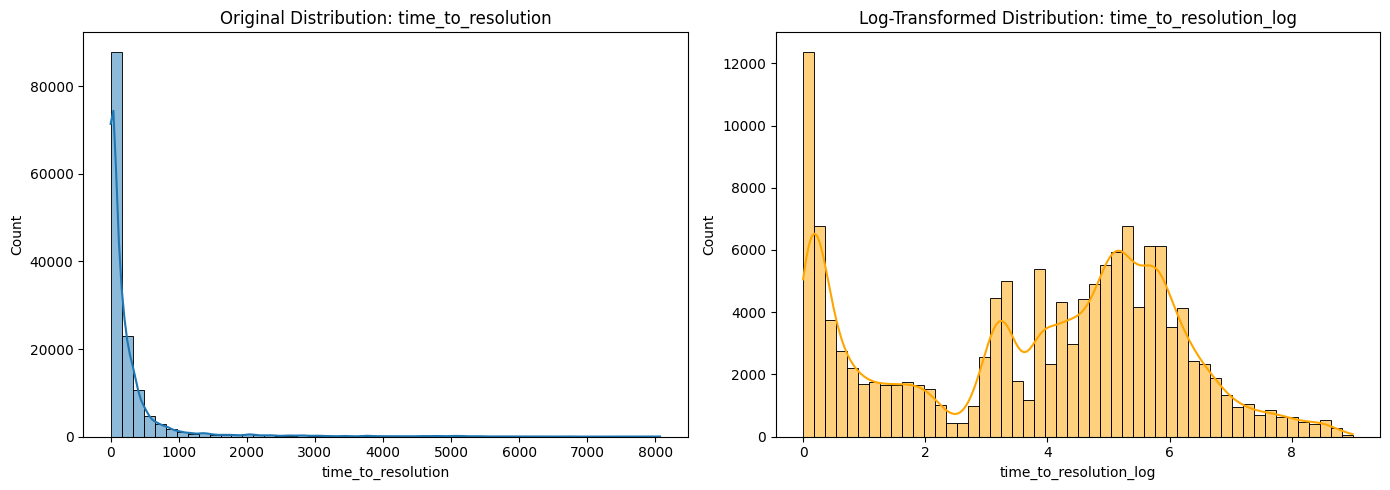

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compare original vs. log-transformed side by side
for col in log_columns:
    log_col = col + '_log'
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f"Original Distribution: {col}")

    plt.subplot(1, 2, 2)
    sns.histplot(df[log_col], kde=True, bins=50, color='orange')
    plt.title(f"Log-Transformed Distribution: {log_col}")

    plt.tight_layout()
    plt.show()

The distribution of the log-transformed time_to_resolution is significantly more symmetric and bell-shaped compared to the original, which was highly right-skewed. This transformation reduces the influence of extreme outliers and helps stabilize variance across the dataset.

In [16]:
import numpy as np
df['time_to_resolution_log'] = np.log1p(df['time_to_resolution'])

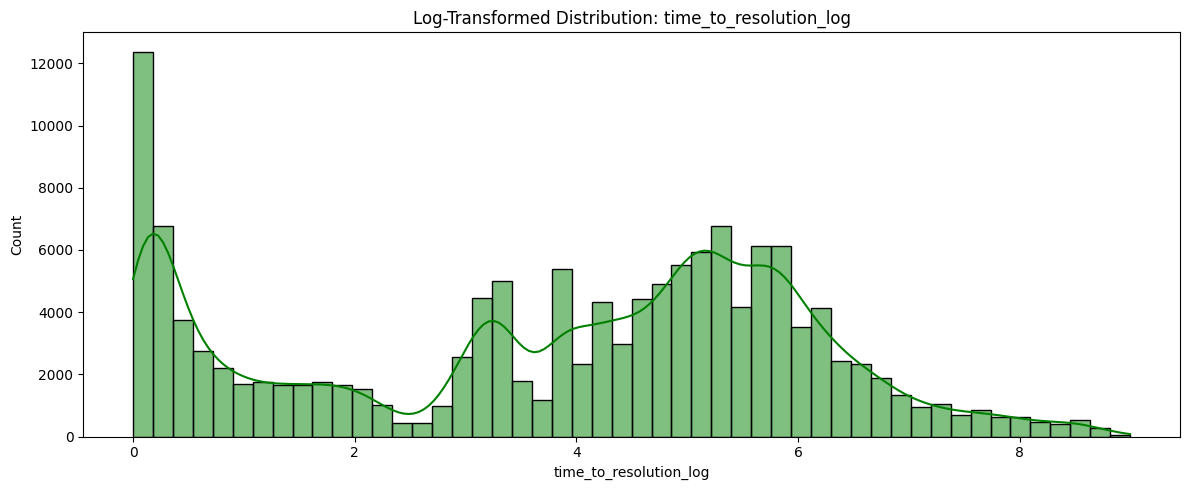

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the log-transformed columns
plt.figure(figsize=(12, 5))

# time_to_resolution_log
sns.histplot(df['time_to_resolution_log'], kde=True, bins=50, color='green')
plt.title("Log-Transformed Distribution: time_to_resolution_log")

plt.tight_layout()
plt.show()

#### Avg Time by Incident State

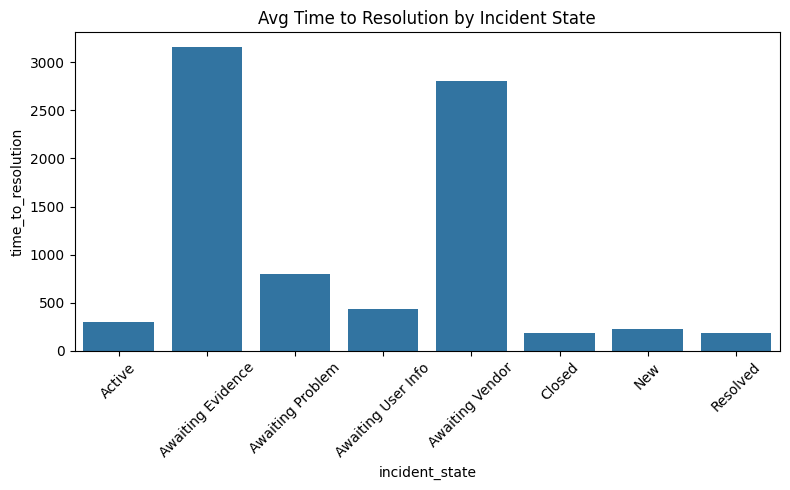

In [18]:
if "incident_state" in df.columns:
    avg_state = df.groupby("incident_state")["time_to_resolution"].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(x="incident_state", y="time_to_resolution", data=avg_state)
    plt.title("Avg Time to Resolution by Incident State")
    plt.xticks(rotation=45)
    plt.tight_layout()

##### **Observation: Avg Time to Resolution by Incident State**

- **"Awaiting Vendor"** and **"Awaiting Evidence"** states have the **highest average resolution times** (500–580+ hours), suggesting significant delays when external input or third-party involvement is required.
- **"Awaiting Problem"** and **"Awaiting User Info"** also show elevated resolution times, reflecting dependencies on internal problem teams or users.
- In contrast, **"Closed"**, **"Resolved"**, and **"New"** states have the **lowest average times** (near or below 150 hours), indicating that these are either completed or just initiated cases.
- **"Active"** sits in the middle, reflecting ongoing handling without external blockers.

#### Avg Time by Hour of Day

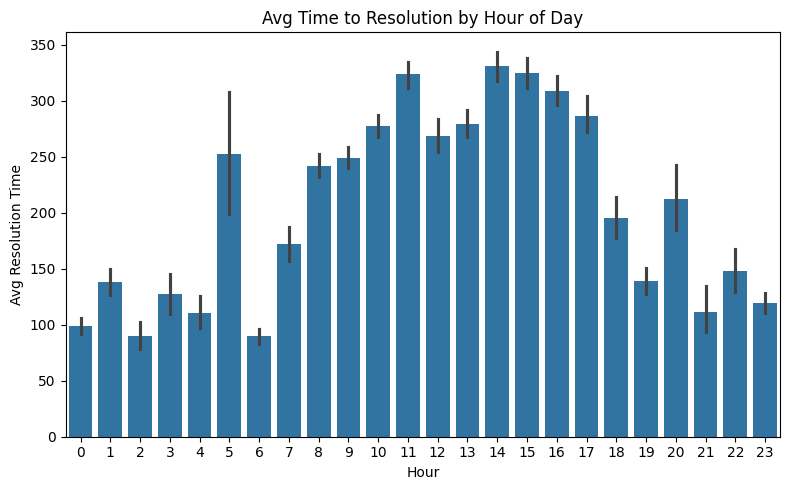

In [19]:
plt.figure(figsize=(8, 5))
sns.barplot(x="opened_hour", y="time_to_resolution", data=df)
plt.title("Avg Time to Resolution by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Avg Resolution Time")
plt.tight_layout()

##### **Observation: Avg Time to Resolution by Hour of Day**

- Resolution times are **highest during working hours** (10:00 to 17:00), peaking around **15:00–16:00** with averages close to 200 hours.
- **Early morning (0:00–6:00)** and **late night (after 20:00)** hours show **significantly lower resolution times**, with the lowest around **2:00 and 21:00**.
- This trend may indicate that tickets created or handled during **peak business hours** tend to be more complex or take longer to resolve.
- Alternatively, tickets logged during **off-hours** may be simpler or resolved faster due to lower system load or automated handling.

#### Avg Time by Day of Week

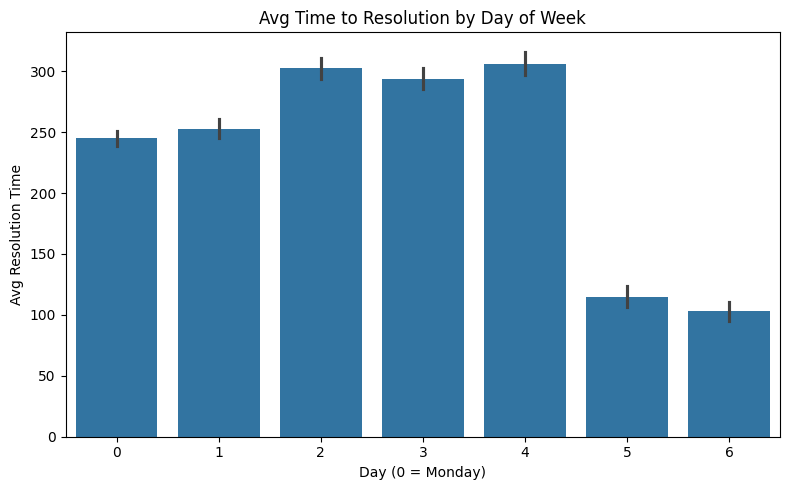

In [20]:
plt.figure(figsize=(8, 5))
sns.barplot(x="opened_dayofweek", y="time_to_resolution", data=df)
plt.title("Avg Time to Resolution by Day of Week")
plt.xlabel("Day (0 = Monday)")
plt.ylabel("Avg Resolution Time")
plt.tight_layout()


##### **Observation: Avg Time to Resolution by Day of Week**

- Average resolution time is **highest on midweek days** (Tuesday to Friday), peaking around **Day 4 (Thursday)** with values close to **185 hours**.
- **Monday (Day 0)** and **Tuesday (Day 1)** show slightly lower resolution times, though still relatively high.
- A noticeable **drop occurs over the weekend**, with **Saturday (Day 5)** and especially **Sunday (Day 6)** showing the **lowest resolution times** — near or below 100 hours.

#### Treating missing values.

In [21]:
import numpy as np
df = df.copy()
df.replace("?", "Unknown", inplace=True)
df.isnull().sum()
(df == "Unknown").sum()

number                          0
incident_state                  0
active                          0
reassignment_count              0
reopen_count                    0
sys_mod_count                   0
made_sla                        0
caller_id                      29
opened_by                    4835
sys_created_by              53076
sys_created_at              53076
sys_updated_by                  0
sys_updated_at                  0
contact_type                    0
location                       76
category                       78
subcategory                   111
u_symptom                   32959
cmdb_ci                    141262
impact                          0
urgency                         0
priority                        0
assignment_group            14213
assigned_to                 27496
knowledge                       0
u_priority_confirmation         0
notify                          0
problem_id                 139412
rfc                        140716
vendor        

#### Dropping the following columns

1. **System metadata**: sys_created_by, sys_created_at, sys_updated_by, sys_updated_at, closed_at – not useful for prediction.

sys_created_at and sys_updated_at refer to when the record was inserted or modified in the system, not when the actual incident occurred or was resolved.

closed_at reflects when the ticket was formally closed, which often happens after the resolution, making it irrelevant for predicting resolution time.

These values are technical/logging artifacts and do not reflect incident complexity, behavior, or urgency.

Including them could introduce noise or data leakage without improving predictive performance.

3. **High missing values**: cmdb_ci, problem_id, rfc, vendor, caused_by – over 95% missing or "Unknown".

4. Outcome-related: active, made_sla – could leak target info

   -These values are often set after the ticket is resolved, meaning they depend on or reflect the target (time_to_resolution).

    -Including them would create data leakage, where the model uses future or derived info to make predictions — leading to overfitting and misleading evaluation results.

In [22]:
cols_to_drop = [
    "sys_created_by", "sys_created_at", "cmdb_ci", "problem_id", "sys_updated_by", "sys_updated_at" , "active" , "made_sla", "rfc", "vendor", "caused_by" , 'closed_at'
]
df.drop(columns=cols_to_drop, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   number                   141707 non-null  object 
 1   incident_state           141707 non-null  object 
 2   reassignment_count       141707 non-null  int64  
 3   reopen_count             141707 non-null  int64  
 4   sys_mod_count            141707 non-null  int64  
 5   caller_id                141707 non-null  object 
 6   opened_by                141707 non-null  object 
 7   contact_type             141707 non-null  object 
 8   location                 141707 non-null  object 
 9   category                 141707 non-null  object 
 10  subcategory              141707 non-null  object 
 11  u_symptom                141707 non-null  object 
 12  impact                   141707 non-null  object 
 13  urgency                  141707 non-null  object 
 14  priority 

### MODEL SPECIFIC ENCODING 

### 1.SVM_MLP

In [24]:
print("Total rows      :", len(df))
print("Unique 'number' :", df['number'].nunique())
print("Duplicates in 'number':", df.duplicated('number').sum())

Total rows      : 141707
Unique 'number' : 24918
Duplicates in 'number': 116789


In [25]:
# Step 0: Copy original
X_svm_mlp = df.copy()
y = X_svm_mlp['time_to_resolution_log']

In [26]:
#  Step 1: Drop unneeded ID/time columns
X_svm_mlp.drop(columns=['time_to_resolution','time_to_resolution_log'], inplace=True)

In [27]:
# Step 2: Cyclical encoding for time
import numpy as np
X_svm_mlp['hour_sin'] = np.sin(2 * np.pi * X_svm_mlp['opened_hour'] / 24)
X_svm_mlp['hour_cos'] = np.cos(2 * np.pi * X_svm_mlp['opened_hour'] / 24)
X_svm_mlp.drop(columns='opened_hour', inplace=True)

X_svm_mlp['day_sin'] = np.sin(2 * np.pi * X_svm_mlp['opened_dayofweek'] / 7)
X_svm_mlp['day_cos'] = np.cos(2 * np.pi * X_svm_mlp['opened_dayofweek'] / 7)
X_svm_mlp.drop(columns='opened_dayofweek', inplace=True)

In [28]:
X_svm_mlp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   number                   141707 non-null  object 
 1   incident_state           141707 non-null  object 
 2   reassignment_count       141707 non-null  int64  
 3   reopen_count             141707 non-null  int64  
 4   sys_mod_count            141707 non-null  int64  
 5   caller_id                141707 non-null  object 
 6   opened_by                141707 non-null  object 
 7   contact_type             141707 non-null  object 
 8   location                 141707 non-null  object 
 9   category                 141707 non-null  object 
 10  subcategory              141707 non-null  object 
 11  u_symptom                141707 non-null  object 
 12  impact                   141707 non-null  object 
 13  urgency                  141707 non-null  object 
 14  priority 

We used frequency count because some columns had too many unique values (like caller_id, assigned_to).
Instead of creating thousands of new columns (which happens with one-hot encoding), we just counted how often each value appears.

In [29]:
#Step3 frequency encoding 

import numpy as np

high_card_cols = ["number", 'caller_id', 'assigned_to', 'opened_by', 'resolved_by',
                  'u_symptom', "closed_code", "location", "category", "subcategory", "assignment_group"]

for col in high_card_cols:
    if col in X_svm_mlp.columns:
        # Step 1: Raw frequency counts
        raw_freq_map = X_svm_mlp[col].value_counts()
        X_svm_mlp[col + '_freq_raw'] = X_svm_mlp[col].map(raw_freq_map)

        # Step 2: Log1p transform
        log_freq_map = raw_freq_map.apply(np.log1p)
        X_svm_mlp[col + '_freq'] = X_svm_mlp[col].map(log_freq_map)

        # Step 3: Display sample comparison (optional)
        print(f"\n {col}: Raw vs Log-Transformed Frequency")
        display(X_svm_mlp[[col, col + '_freq_raw', col + '_freq']].head())



 number: Raw vs Log-Transformed Frequency


,number,number_freq_raw,number_freq
0,INC0000045,4,1.609438
1,INC0000045,4,1.609438
2,INC0000045,4,1.609438
3,INC0000045,4,1.609438
4,INC0000047,9,2.302585



 caller_id: Raw vs Log-Transformed Frequency


,caller_id,caller_id_freq_raw,caller_id_freq
0,Caller 2403,86,4.465908
1,Caller 2403,86,4.465908
2,Caller 2403,86,4.465908
3,Caller 2403,86,4.465908
4,Caller 2403,86,4.465908



 assigned_to: Raw vs Log-Transformed Frequency


,assigned_to,assigned_to_freq_raw,assigned_to_freq
0,Unknown,27496,10.221832
1,Unknown,27496,10.221832
2,Unknown,27496,10.221832
3,Unknown,27496,10.221832
4,Resolver 89,1059,6.966024



 opened_by: Raw vs Log-Transformed Frequency


,opened_by,opened_by_freq_raw,opened_by_freq
0,Opened by 8,4131,8.326517
1,Opened by 8,4131,8.326517
2,Opened by 8,4131,8.326517
3,Opened by 8,4131,8.326517
4,Opened by 397,3579,8.183118



 resolved_by: Raw vs Log-Transformed Frequency


,resolved_by,resolved_by_freq_raw,resolved_by_freq
0,Resolved by 149,16,2.833213
1,Resolved by 149,16,2.833213
2,Resolved by 149,16,2.833213
3,Resolved by 149,16,2.833213
4,Resolved by 81,1103,7.006695



 u_symptom: Raw vs Log-Transformed Frequency


,u_symptom,u_symptom_freq_raw,u_symptom_freq
0,Symptom 72,13,2.639057
1,Symptom 72,13,2.639057
2,Symptom 72,13,2.639057
3,Symptom 72,13,2.639057
4,Symptom 471,418,6.037871



 closed_code: Raw vs Log-Transformed Frequency


,closed_code,closed_code_freq_raw,closed_code_freq
0,code 5,4469,8.405144
1,code 5,4469,8.405144
2,code 5,4469,8.405144
3,code 5,4469,8.405144
4,code 5,4469,8.405144



 location: Raw vs Log-Transformed Frequency


,location,location_freq_raw,location_freq
0,Location 143,19245,9.865059
1,Location 143,19245,9.865059
2,Location 143,19245,9.865059
3,Location 143,19245,9.865059
4,Location 165,425,6.054439



 category: Raw vs Log-Transformed Frequency


,category,category_freq_raw,category_freq
0,Category 55,801,6.687109
1,Category 55,801,6.687109
2,Category 55,801,6.687109
3,Category 55,801,6.687109
4,Category 40,3760,8.232440



 subcategory: Raw vs Log-Transformed Frequency


,subcategory,subcategory_freq_raw,subcategory_freq
0,Subcategory 170,3349,8.116716
1,Subcategory 170,3349,8.116716
2,Subcategory 170,3349,8.116716
3,Subcategory 170,3349,8.116716
4,Subcategory 215,356,5.877736



 assignment_group: Raw vs Log-Transformed Frequency


,assignment_group,assignment_group_freq_raw,assignment_group_freq
0,Group 56,1076,6.981935
1,Group 56,1076,6.981935
2,Group 56,1076,6.981935
3,Group 56,1076,6.981935
4,Group 70,43474,10.679941


We applied log transformation to compress large frequency values, reduce skewness, and prevent dominant features from biasing SVM and MLP models.

In [30]:
# Step 1: Drop raw frequency columns (ending with '_freq_raw')
X_svm_mlp.drop(
    columns=[col + '_freq_raw' for col in high_card_cols if col + '_freq_raw' in X_svm_mlp.columns],
    inplace=True
)

# Step 2: Drop the original string columns
X_svm_mlp.drop(
    columns=[col for col in high_card_cols if col in X_svm_mlp.columns],
    inplace=True
)

print(" Dropped original categorical and raw frequency columns.")


 Dropped original categorical and raw frequency columns.


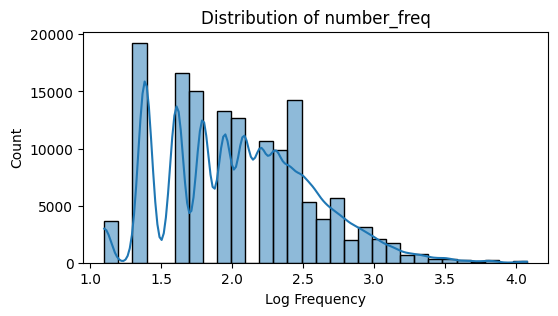

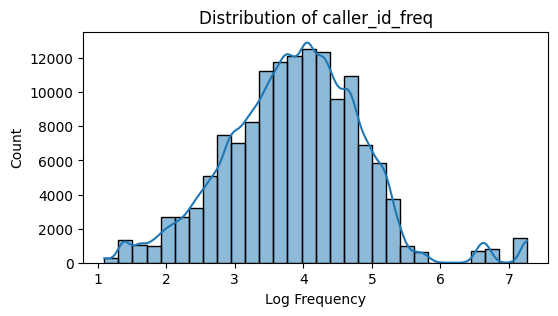

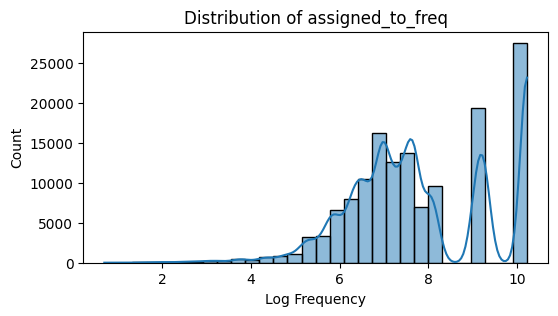

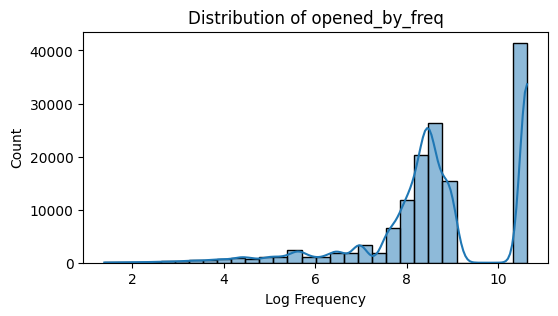

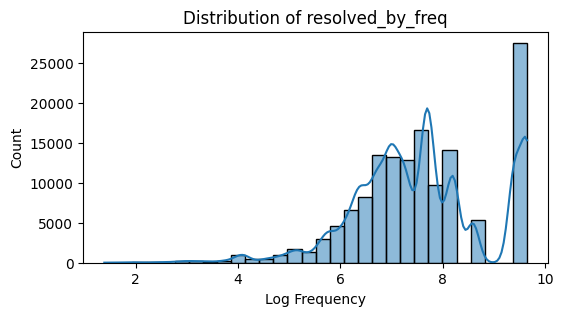

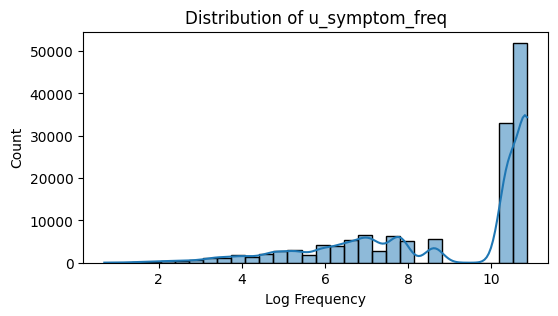

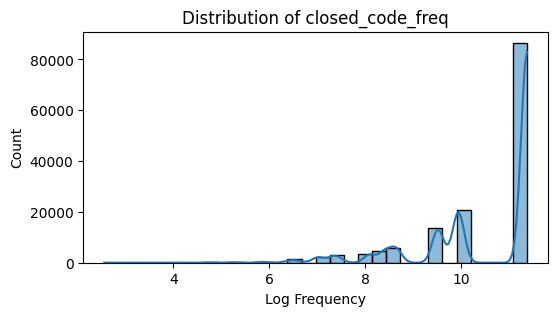

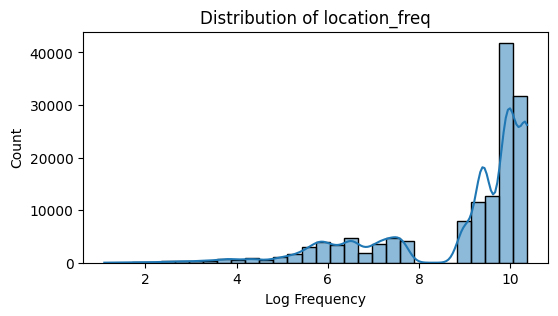

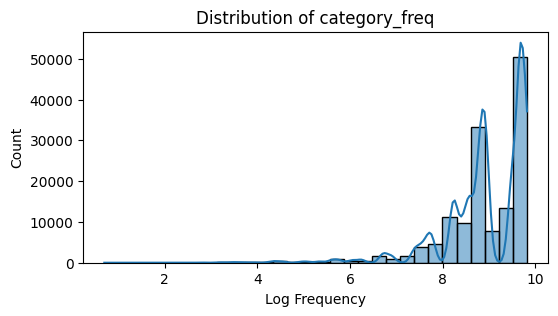

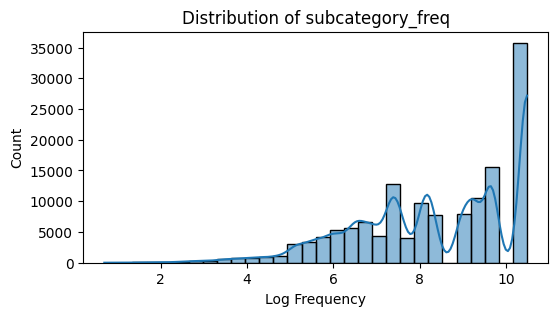

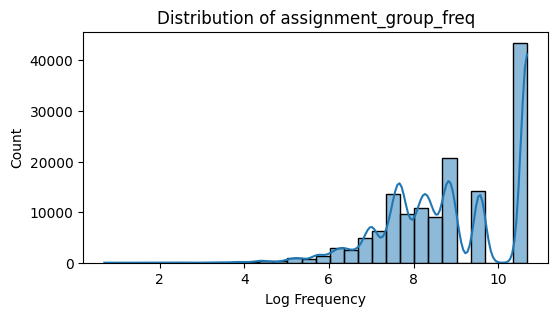

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

freq_cols = [col for col in X_svm_mlp.columns if col.endswith('_freq')]

for col in freq_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(X_svm_mlp[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel("Log Frequency")
    plt.show()


The histograms visualize the distributions of log-transformed frequency-encoded high-cardinality categorical features. The transformation effectively compresses extreme frequency values and reduces right-skewness. This results in more balanced, normalized input distributions, especially important for SVM and MLP models, which are sensitive to feature scale and variance in input features.

In [32]:
X_svm_mlp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 28 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   incident_state           141707 non-null  object 
 1   reassignment_count       141707 non-null  int64  
 2   reopen_count             141707 non-null  int64  
 3   sys_mod_count            141707 non-null  int64  
 4   contact_type             141707 non-null  object 
 5   impact                   141707 non-null  object 
 6   urgency                  141707 non-null  object 
 7   priority                 141707 non-null  object 
 8   knowledge                141707 non-null  bool   
 9   u_priority_confirmation  141707 non-null  bool   
 10  notify                   141707 non-null  object 
 11  opened_month             141707 non-null  int32  
 12  opened_weekend           141707 non-null  int64  
 13  hour_sin                 141707 non-null  float64
 14  hour_cos 

#### OUTLIERS DETECTION

In [33]:
original_X_svm_mlp = X_svm_mlp.copy()

In [34]:
iqr_bounds = {}  # Store bounds for each column

numeric_cols = X_svm_mlp.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    Q1 = X_svm_mlp[col].quantile(0.25)
    Q3 = X_svm_mlp[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_bounds[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

    outliers = ((X_svm_mlp[col] < lower_bound) | (X_svm_mlp[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers capped")

    X_svm_mlp[col] = X_svm_mlp[col].clip(lower=lower_bound, upper=upper_bound)

print(" IQR capping complete. Bounds stored in `iqr_bounds`.")


reassignment_count: 19635 outliers capped
reopen_count: 2314 outliers capped
sys_mod_count: 10897 outliers capped
opened_weekend: 6099 outliers capped
hour_sin: 0 outliers capped
hour_cos: 12102 outliers capped
day_sin: 0 outliers capped
day_cos: 0 outliers capped
number_freq: 597 outliers capped
caller_id_freq: 4545 outliers capped
assigned_to_freq: 431 outliers capped
opened_by_freq: 2684 outliers capped
resolved_by_freq: 2500 outliers capped
u_symptom_freq: 153 outliers capped
closed_code_freq: 7454 outliers capped
location_freq: 2647 outliers capped
category_freq: 4830 outliers capped
subcategory_freq: 86 outliers capped
assignment_group_freq: 88 outliers capped
 IQR capping complete. Bounds stored in `iqr_bounds`.


In [35]:
for col, bounds in iqr_bounds.items():
    print(f"{col}: Lower = {bounds['lower_bound']:.2f}, Upper = {bounds['upper_bound']:.2f}")

reassignment_count: Lower = -1.50, Upper = 2.50
reopen_count: Lower = 0.00, Upper = 0.00
sys_mod_count: Lower = -6.50, Upper = 13.50
opened_weekend: Lower = 0.00, Upper = 0.00
hour_sin: Lower = -2.83, Upper = 2.83
hour_cos: Lower = -1.42, Upper = 0.05
day_sin: Lower = -1.17, Upper = 1.95
day_cos: Lower = -3.19, Upper = 2.91
number_freq: Lower = 0.43, Upper = 3.58
caller_id_freq: Lower = 1.40, Upper = 6.36
assigned_to_freq: Lower = 2.92, Upper = 13.08
opened_by_freq: Lower = 4.30, Upper = 14.43
resolved_by_freq: Lower = 4.49, Upper = 10.50
u_symptom_freq: Lower = 1.39, Upper = 16.54
closed_code_freq: Lower = 7.79, Upper = 13.51
location_freq: Lower = 4.13, Upper = 13.56
category_freq: Lower = 6.86, Upper = 11.37
subcategory_freq: Lower = 1.89, Upper = 15.64
assignment_group_freq: Lower = 3.24, Upper = 15.14


In [36]:
# Restore the two columns from the original data
X_svm_mlp['reopen_count'] = original_X_svm_mlp['reopen_count']
X_svm_mlp['opened_weekend'] = original_X_svm_mlp['opened_weekend']

In [37]:
print("reopen_count restored correctly:", X_svm_mlp['reopen_count'].equals(original_X_svm_mlp['reopen_count']))
print("opened_weekend restored correctly:", X_svm_mlp['opened_weekend'].equals(original_X_svm_mlp['opened_weekend']))

reopen_count restored correctly: True
opened_weekend restored correctly: True


We  **revert the outlier capping** for the columns **`reopen_count`** and **`opened_weekend`** because the IQR method identified **all values outside a very narrow range (or no range at all)** as outliers. Specifically:

- For both columns, the calculated IQR was **zero or very small**, resulting in both the **lower and upper bounds being equal** (e.g., 0.00).
- This caused **most or all values** in these columns to be treated as outliers, which is **not meaningful or desirable** in this context.

These two columns represent **discrete or binary features**:
- `reopen_count` is a count variable that may have legitimate higher values.
- `opened_weekend` is a binary indicator (0 or 1), which naturally has very limited range.

Because of the nature of these variables, applying outlier capping **distorted the original information**, so we chose to **restore their original values** from the unmodified dataset to retain their interpretability and predictive power.

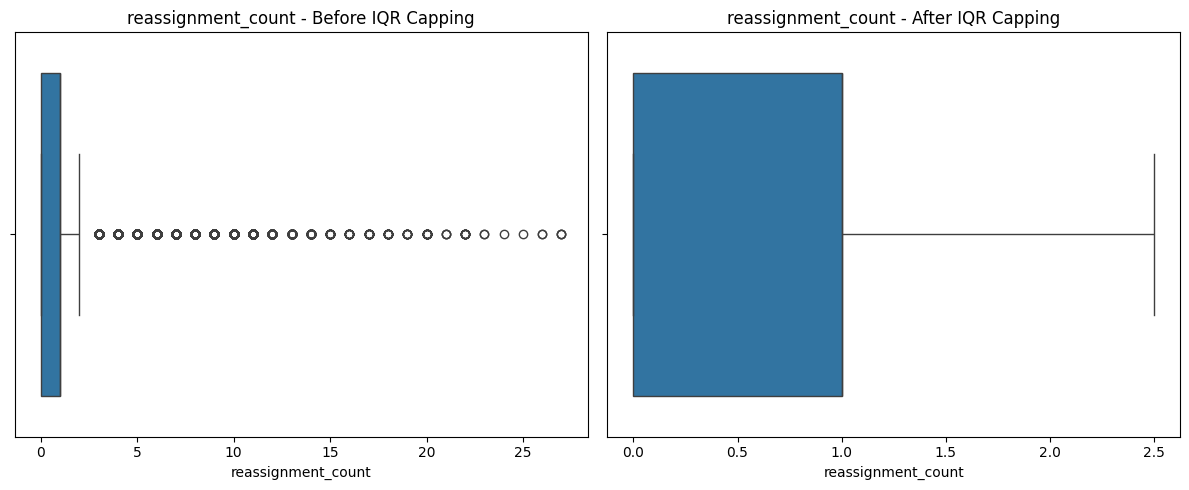

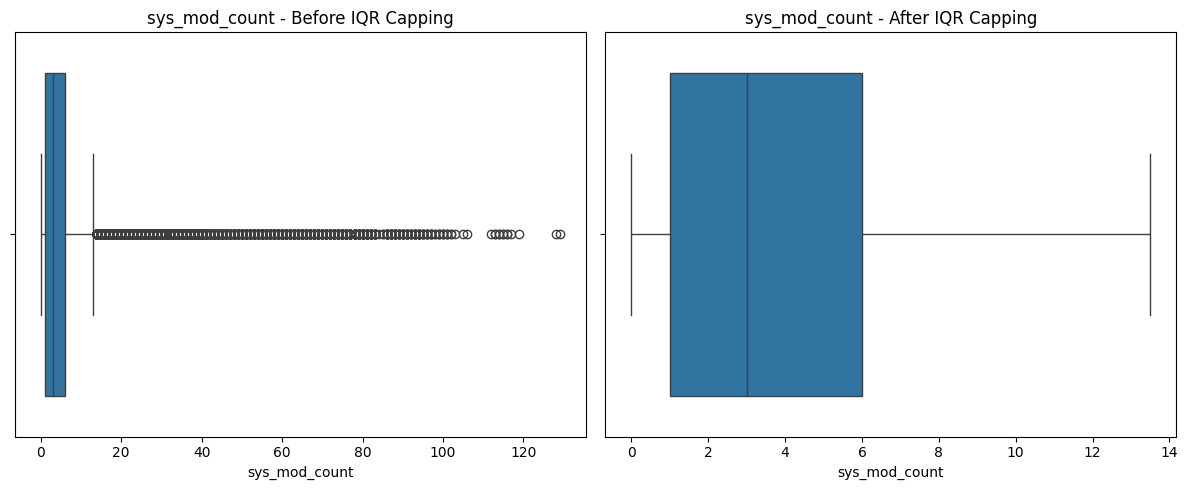

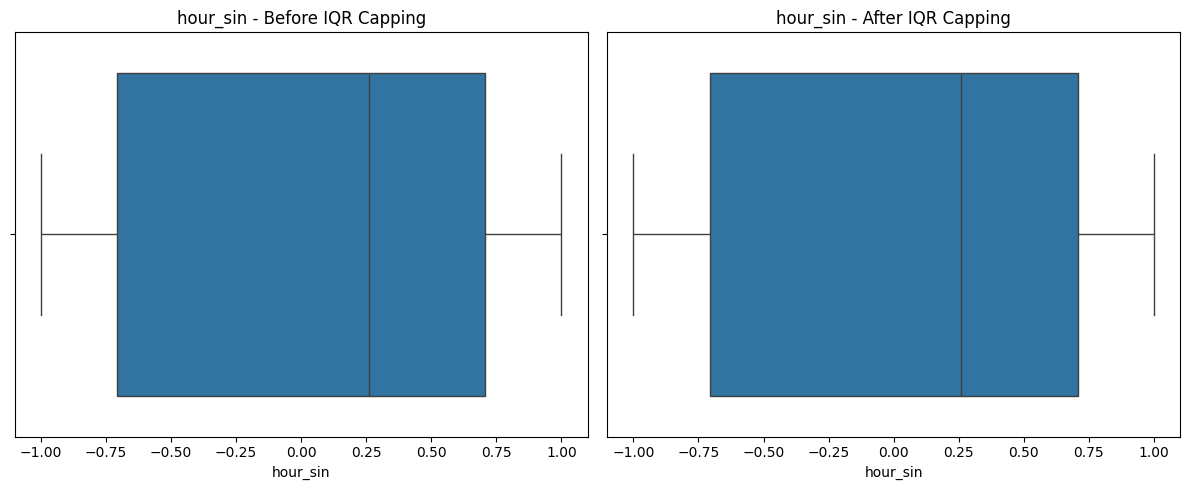

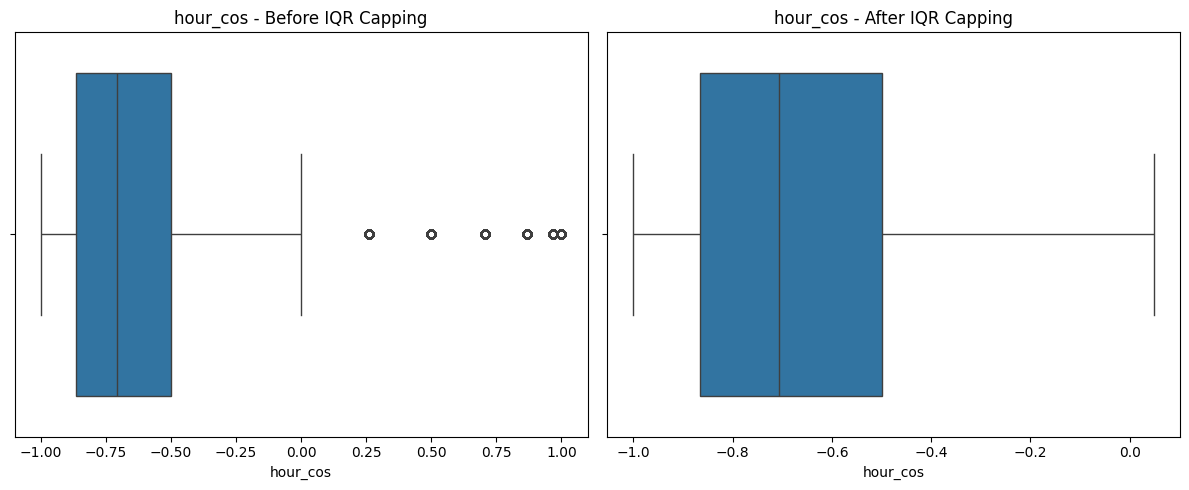

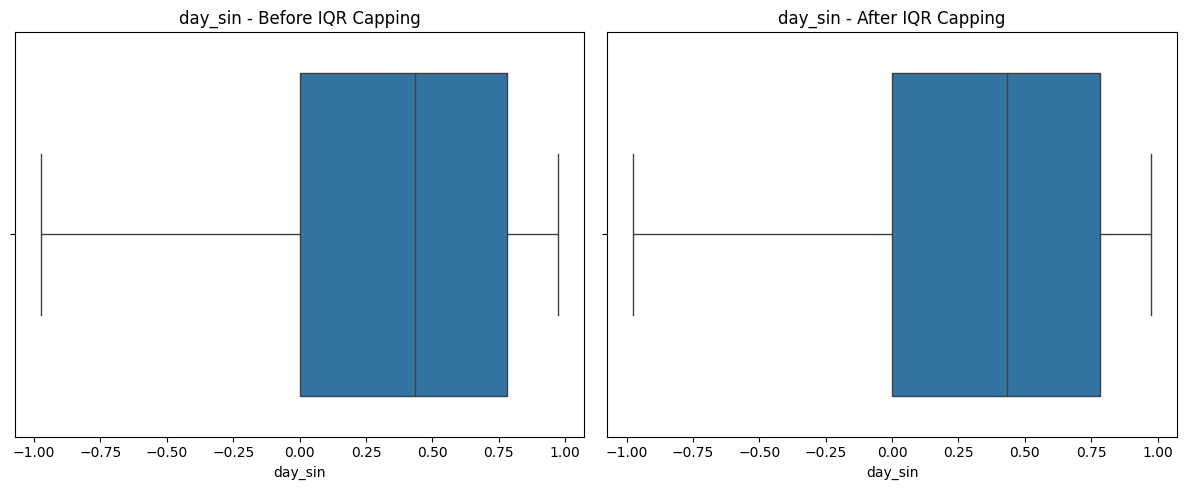

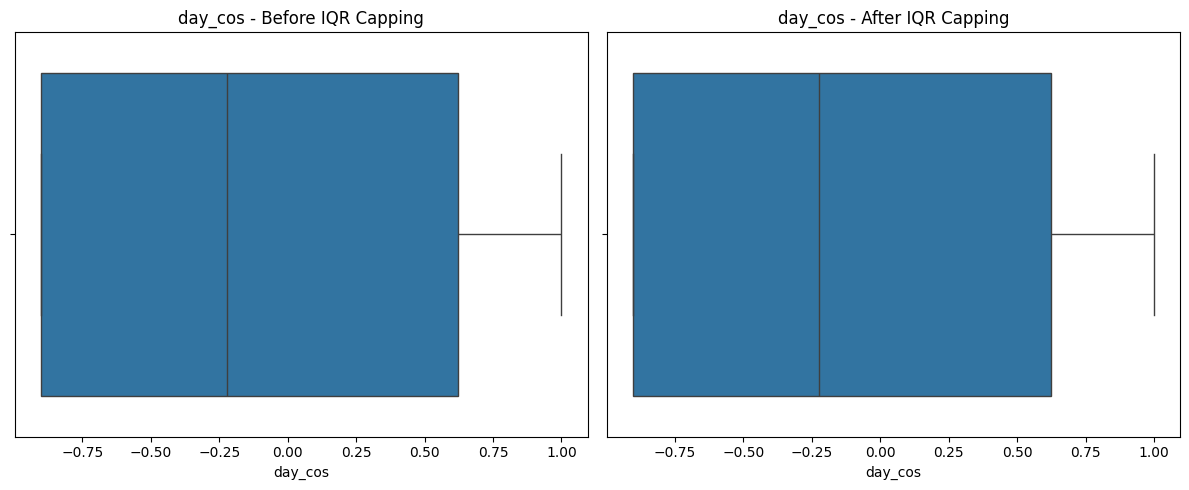

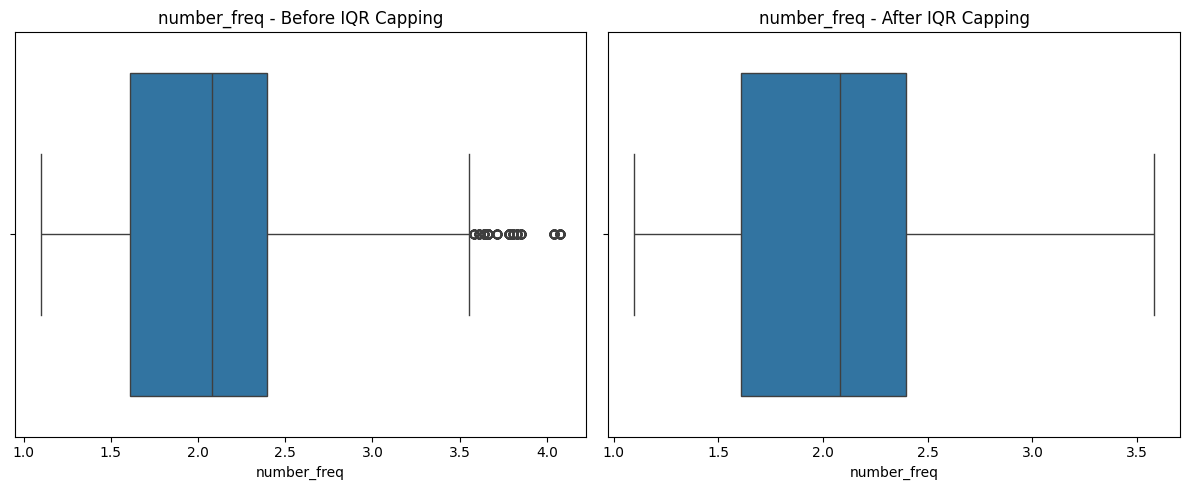

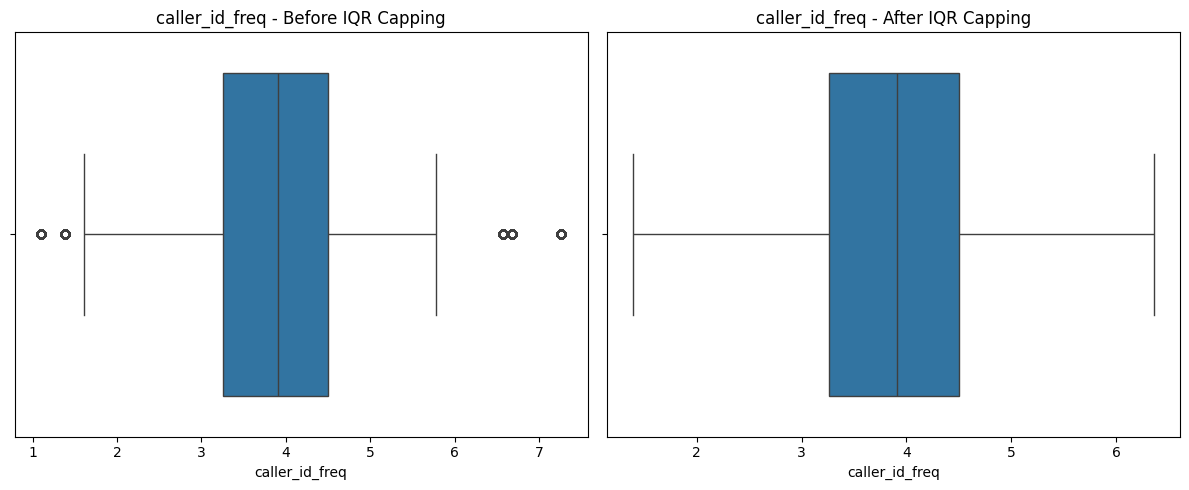

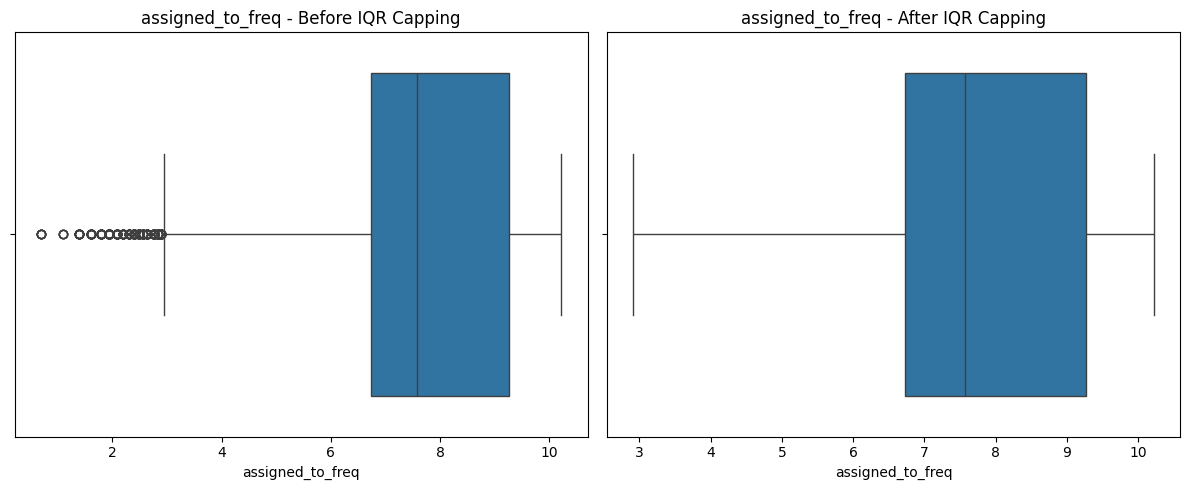

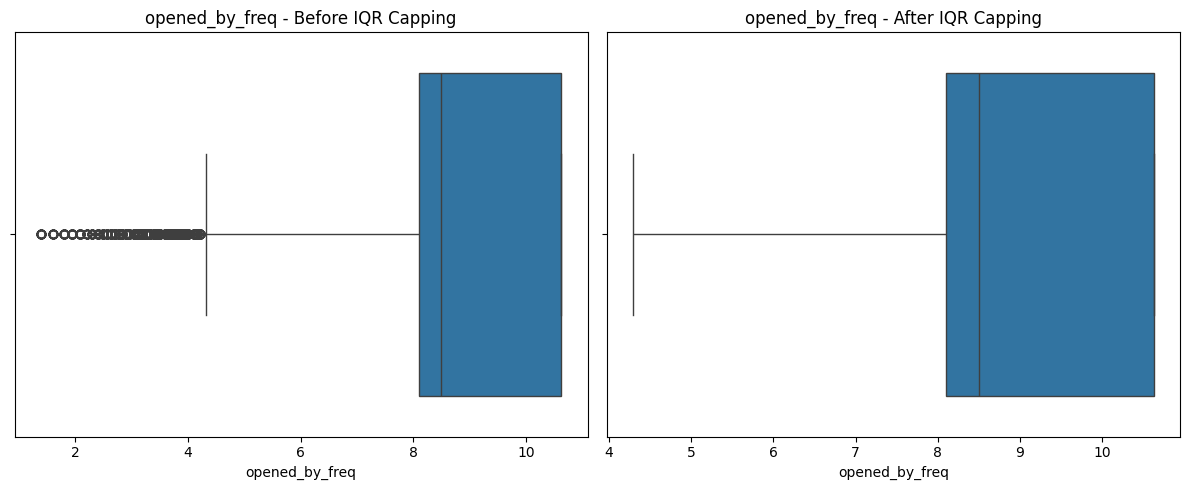

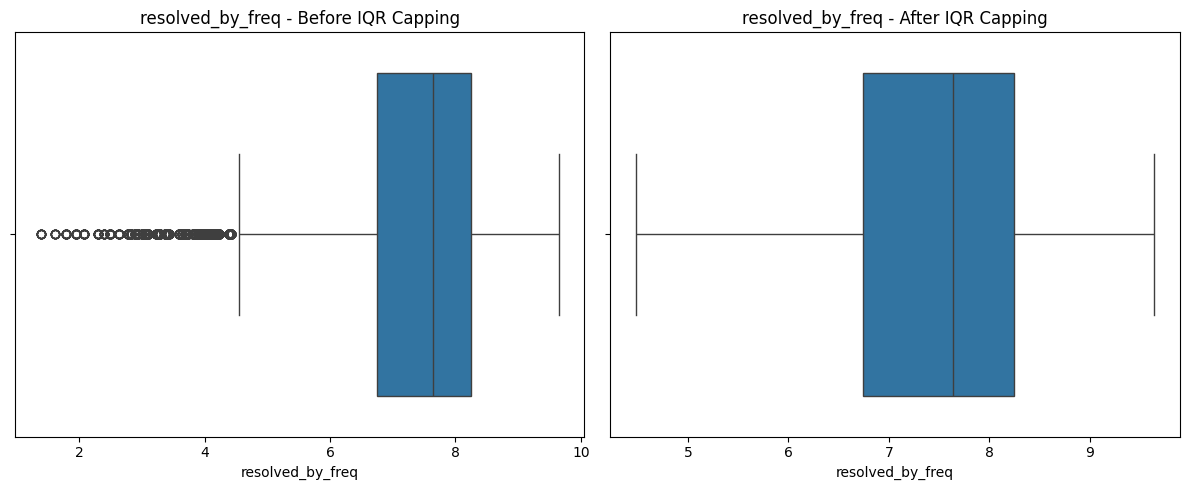

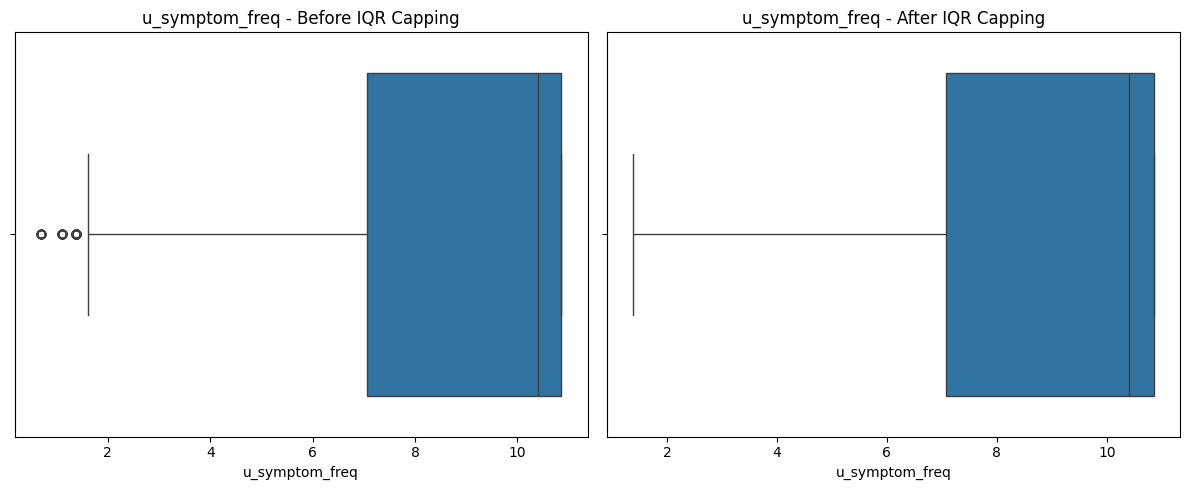

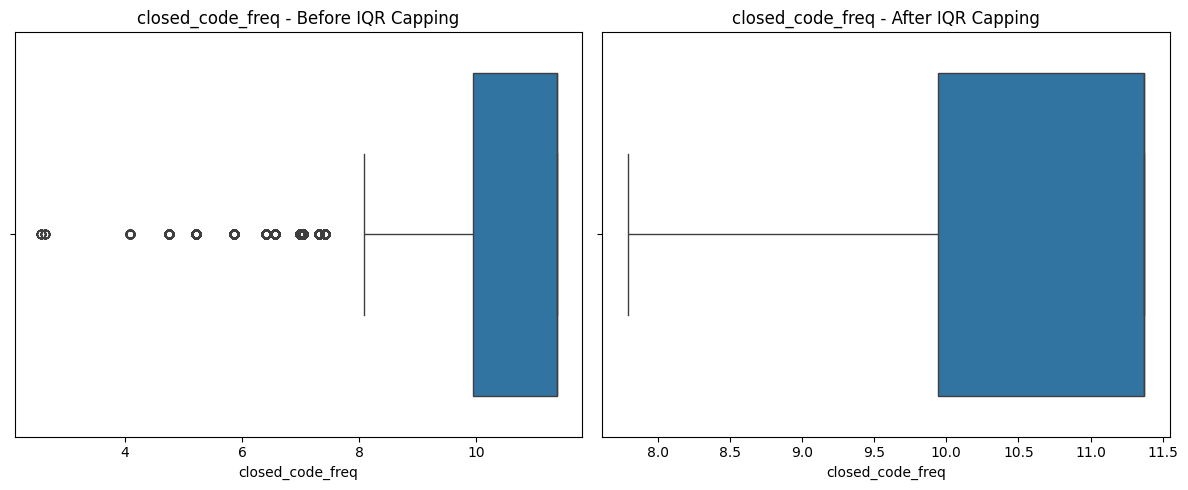

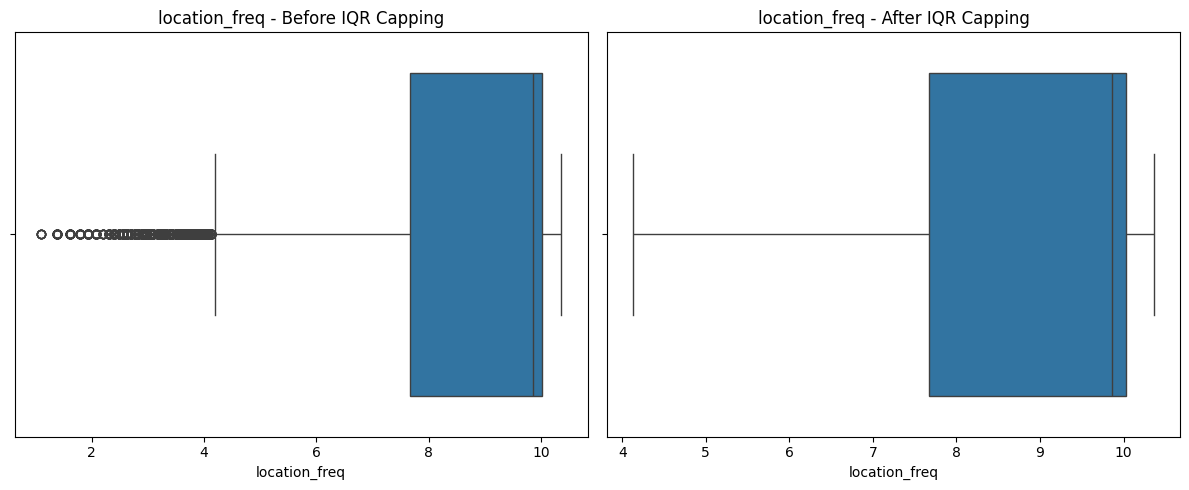

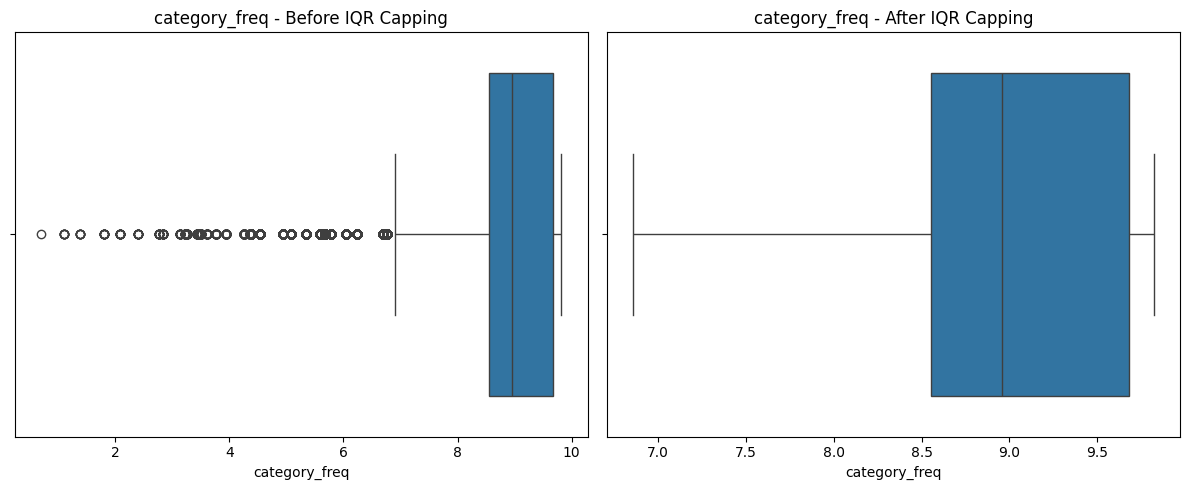

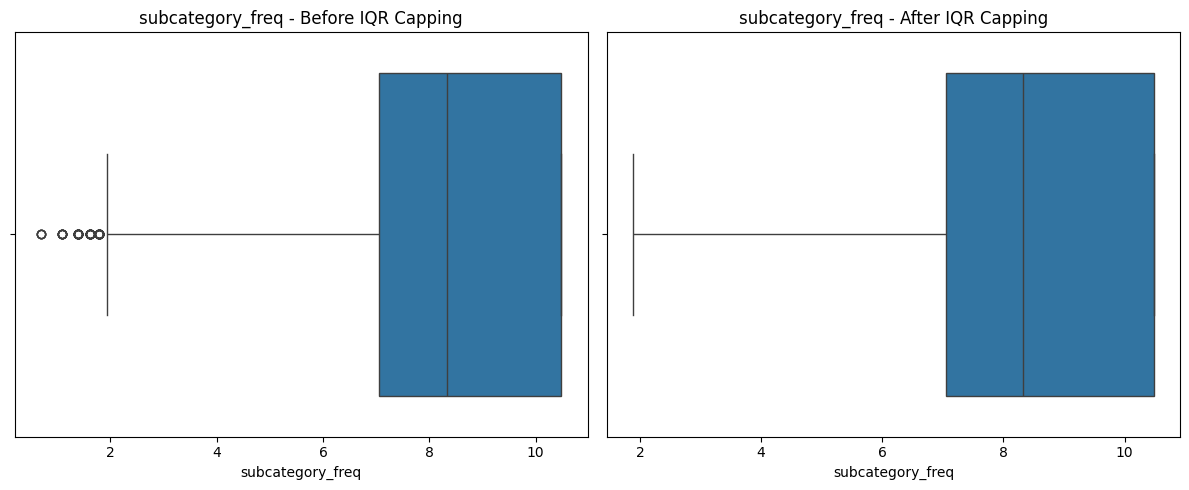

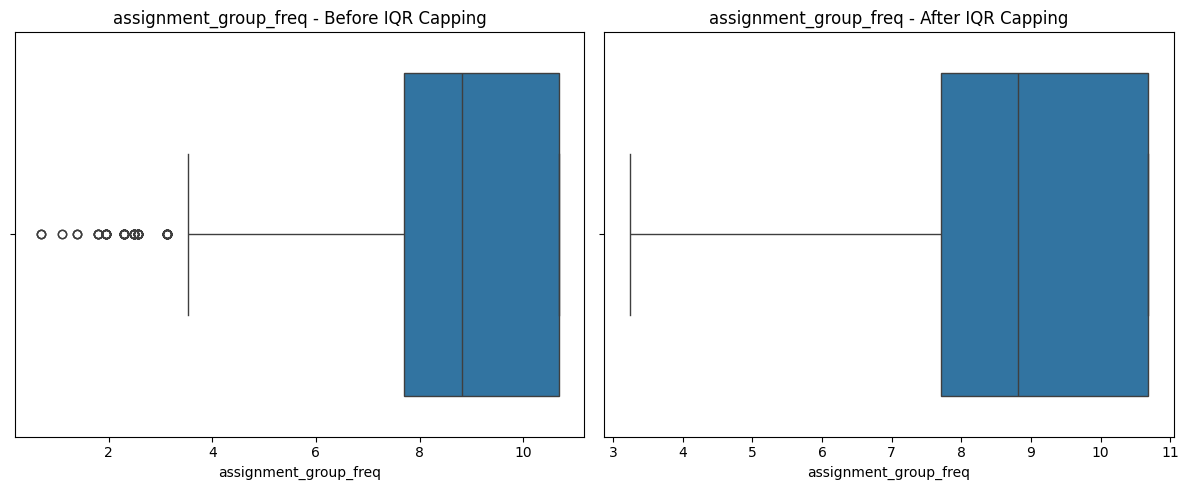

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numeric columns excluding 'reopen_count' and 'opened_weekend'
numeric_cols = X_svm_mlp.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col not in ['reopen_count', 'opened_weekend']]

for col in numeric_cols:
    plt.figure(figsize=(12, 5))

    # Before capping
    plt.subplot(1, 2, 1)
    sns.boxplot(x=original_X_svm_mlp[col])
    plt.title(f'{col} - Before IQR Capping')

    # After capping
    plt.subplot(1, 2, 2)
    sns.boxplot(x=X_svm_mlp[col])
    plt.title(f'{col} - After IQR Capping')

    plt.tight_layout()
    plt.show()


#### LABEL AND ONE-HOT-ENCODING. 

In [39]:
# Get remaining categorical columns to one-hot encode
low_card_cols = X_svm_mlp.select_dtypes(include=['object', 'bool']).columns.tolist()
print("One-hot encoding these:", low_card_cols)

One-hot encoding these: ['incident_state', 'contact_type', 'impact', 'urgency', 'priority', 'knowledge', 'u_priority_confirmation', 'notify']


In [40]:
cols_to_convert = ['impact', 'urgency', 'priority']

for col in cols_to_convert:
    if col in X_svm_mlp.columns:
        # Extract the numeric prefix as integer
        X_svm_mlp[col] = X_svm_mlp[col].str.extract(r'^(\d+)').astype(float).astype('Int64')


In [41]:
X_svm_mlp.head(5)

,incident_state,reassignment_count,reopen_count,sys_mod_count,contact_type,impact,urgency,priority,knowledge,u_priority_confirmation,...,caller_id_freq,assigned_to_freq,opened_by_freq,resolved_by_freq,u_symptom_freq,closed_code_freq,location_freq,category_freq,subcategory_freq,assignment_group_freq
0,New,0.0,0,0.0,Phone,2,2,3,True,False,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
1,Resolved,0.0,0,2.0,Phone,2,2,3,True,False,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
2,Resolved,0.0,0,3.0,Phone,2,2,3,True,False,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
3,Closed,0.0,0,4.0,Phone,2,2,3,True,False,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
4,New,0.0,0,0.0,Phone,2,2,3,True,False,...,4.465908,6.966024,8.183118,7.006695,6.037871,8.405144,6.054439,8.232440,5.877736,10.679941


In [42]:
bool_cols = ['knowledge', 'u_priority_confirmation']
for col in bool_cols:
    X_svm_mlp[col] = X_svm_mlp[col].astype(int)


In [43]:
X_svm_mlp.head(5)

,incident_state,reassignment_count,reopen_count,sys_mod_count,contact_type,impact,urgency,priority,knowledge,u_priority_confirmation,...,caller_id_freq,assigned_to_freq,opened_by_freq,resolved_by_freq,u_symptom_freq,closed_code_freq,location_freq,category_freq,subcategory_freq,assignment_group_freq
0,New,0.0,0,0.0,Phone,2,2,3,1,0,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
1,Resolved,0.0,0,2.0,Phone,2,2,3,1,0,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
2,Resolved,0.0,0,3.0,Phone,2,2,3,1,0,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
3,Closed,0.0,0,4.0,Phone,2,2,3,1,0,...,4.465908,10.221832,8.326517,4.485388,2.639057,8.405144,9.865059,6.858479,8.116716,6.981935
4,New,0.0,0,0.0,Phone,2,2,3,1,0,...,4.465908,6.966024,8.183118,7.006695,6.037871,8.405144,6.054439,8.232440,5.877736,10.679941


In [44]:
print("Unique values in 'knowledge':", X_svm_mlp['knowledge'].unique())
print("Unique values in 'u_priority_confirmation':", X_svm_mlp['u_priority_confirmation'].unique())

Unique values in 'knowledge': [1 0]
Unique values in 'u_priority_confirmation': [0 1]


0 → means False 

1 → means True 

#### Cor-relation and Heatmap Analysis for Multicollinearity

In [45]:
# Step 1: Keep only numeric columns
X_numeric = X_svm_mlp.select_dtypes(include='number')

# Step 2: Now compute correlation safely
corr_matrix = X_numeric.corr().abs()

# Step 3: Get upper triangle to find correlated pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 4: List of features with high correlation (e.g., > .75)
to_drop_high_corr = [col for col in upper.columns if any(upper[col] > 0.75)]

print("Highly correlated columns to consider dropping:")
print(to_drop_high_corr)


Highly correlated columns to consider dropping:
['urgency', 'priority']


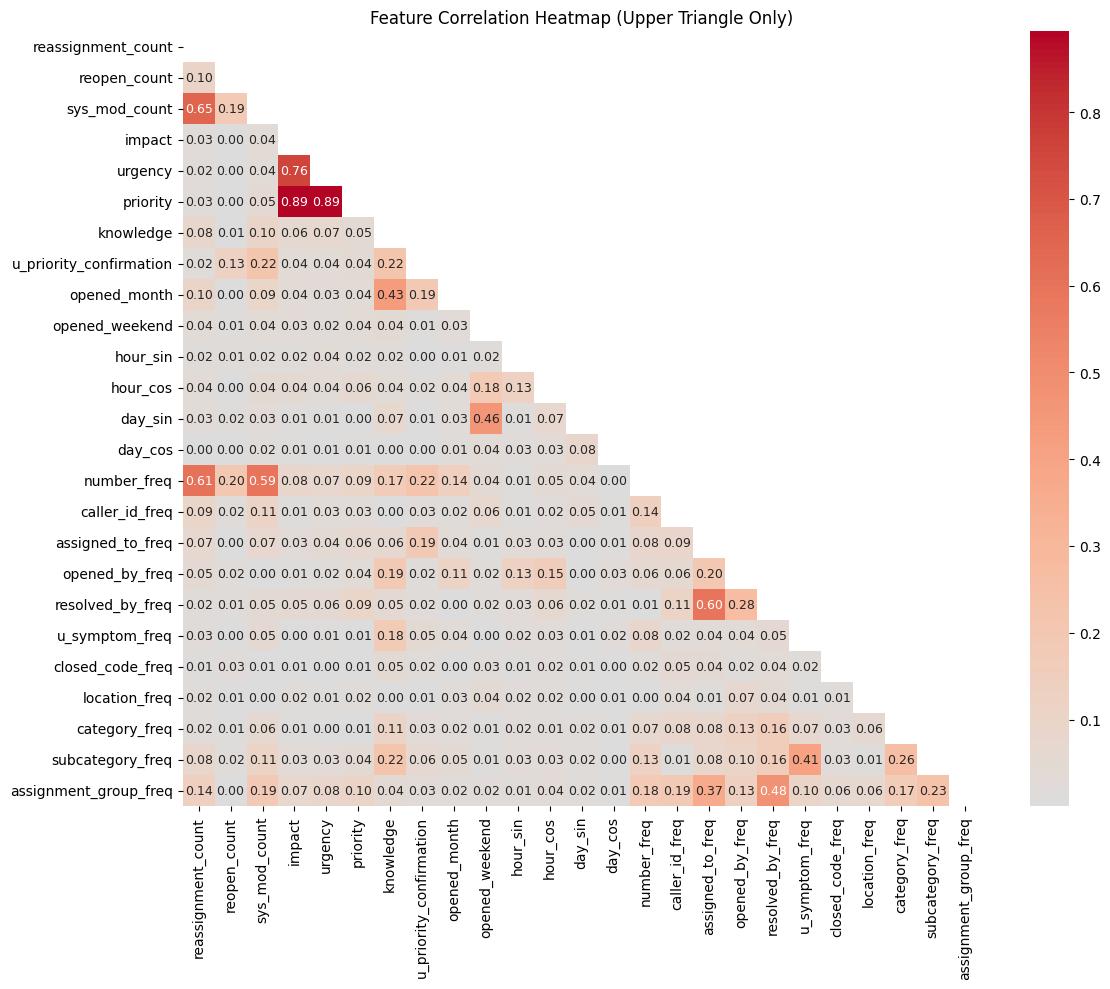

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create mask for the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,                  # hides lower triangle
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9}
)
plt.title("Feature Correlation Heatmap (Upper Triangle Only)")
plt.tight_layout()
plt.show()


#### Correlation-Based Feature Engineering Decision

The correlation heatmap revealed that **`urgency` and `priority` are highly correlated** (correlation coefficient = 0.89), indicating **strong multicollinearity**. This can negatively impact model stability and interpretability, especially in regression tasks.

In contrast, **`impact` showed very low correlation** with both `urgency` and `priority` (~0.03), meaning it provides **independent information** and does not contribute to multicollinearity.

To address this:
- We created a new feature called **`urgency_priority_score`** by combining `urgency` and `priority` using a weighted average.
- We then **dropped the original `urgency` and `priority` columns** to reduce redundancy.
- The `impact` feature was **retained as-is**, since it offers unique, uncorrelated value to the model.

In [47]:
X_svm_mlp['urgency_priority_score'] = (
    0.4 * X_svm_mlp['urgency'] + 0.6 * X_svm_mlp['priority']
)

# Drop the originals
X_svm_mlp.drop(columns=['urgency', 'priority'], inplace=True)


In [48]:
X_svm_mlp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   incident_state           141707 non-null  object 
 1   reassignment_count       141707 non-null  float64
 2   reopen_count             141707 non-null  int64  
 3   sys_mod_count            141707 non-null  float64
 4   contact_type             141707 non-null  object 
 5   impact                   141707 non-null  Int64  
 6   knowledge                141707 non-null  int64  
 7   u_priority_confirmation  141707 non-null  int64  
 8   notify                   141707 non-null  object 
 9   opened_month             141707 non-null  int32  
 10  opened_weekend           141707 non-null  int64  
 11  hour_sin                 141707 non-null  float64
 12  hour_cos                 141707 non-null  float64
 13  day_sin                  141707 non-null  float64
 14  day_cos  

#### Performing Statistical Tests for Categorical Data using Chi-Square Test


In [49]:
import pandas as pd
from scipy.stats import chi2_contingency

def run_chi_square(col1, col2, data):
    contingency = pd.crosstab(data[col1], data[col2])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f" Chi-Square Test between '{col1}' and '{col2}':")
    print(f"Chi² Statistic = {chi2:.2f}, Degrees of Freedom = {dof}, p-value = {p:.4f}")
    if p < 0.05:
        print("Significant association (dependent)\n")
    else:
        print("No significant association (independent)\n")

run_chi_square('incident_state', 'contact_type', X_svm_mlp)
run_chi_square('incident_state', 'notify', X_svm_mlp)
run_chi_square('contact_type', 'notify', X_svm_mlp)



 Chi-Square Test between 'incident_state' and 'contact_type':
Chi² Statistic = 905.24, Degrees of Freedom = 28, p-value = 0.0000
Significant association (dependent)

 Chi-Square Test between 'incident_state' and 'notify':
Chi² Statistic = 58.84, Degrees of Freedom = 7, p-value = 0.0000
Significant association (dependent)

 Chi-Square Test between 'contact_type' and 'notify':
Chi² Statistic = 76595.93, Degrees of Freedom = 4, p-value = 0.0000
Significant association (dependent)



*This suggests that these features are interdependent and should be considered together during analysis or modeling.


In [50]:
X_svm_mlp = pd.get_dummies(X_svm_mlp, columns=['incident_state', 'notify', 'contact_type'], drop_first=True , dtype=int )

In [51]:
X_svm_mlp.head(5)

,reassignment_count,reopen_count,sys_mod_count,impact,knowledge,u_priority_confirmation,opened_month,opened_weekend,hour_sin,hour_cos,...,incident_state_Awaiting User Info,incident_state_Awaiting Vendor,incident_state_Closed,incident_state_New,incident_state_Resolved,notify_Send Email,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service
0,0.0,0,0.0,2,1,0,2,0,0.258819,0.049038,...,0,0,0,1,0,0,0,0,1,0
1,0.0,0,2.0,2,1,0,2,0,0.258819,0.049038,...,0,0,0,0,1,0,0,0,1,0
2,0.0,0,3.0,2,1,0,2,0,0.258819,0.049038,...,0,0,0,0,1,0,0,0,1,0
3,0.0,0,4.0,2,1,0,2,0,0.258819,0.049038,...,0,0,1,0,0,0,0,0,1,0
4,0.0,0,0.0,2,1,0,2,0,0.866025,0.049038,...,0,0,0,1,0,0,0,0,1,0


In [52]:
X_svm_mlp.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   reassignment_count                 141707 non-null  float64
 1   reopen_count                       141707 non-null  int64  
 2   sys_mod_count                      141707 non-null  float64
 3   impact                             141707 non-null  Int64  
 4   knowledge                          141707 non-null  int64  
 5   u_priority_confirmation            141707 non-null  int64  
 6   opened_month                       141707 non-null  int32  
 7   opened_weekend                     141707 non-null  int64  
 8   hour_sin                           141707 non-null  float64
 9   hour_cos                           141707 non-null  float64
 10  day_sin                            141707 non-null  float64
 11  day_cos                            141707 no

### Scaling

In [53]:
from sklearn.preprocessing import StandardScaler

X_numeric = X_svm_mlp.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

In [54]:
X_scaled.head(5)

,reassignment_count,reopen_count,sys_mod_count,impact,knowledge,u_priority_confirmation,opened_month,opened_weekend,hour_sin,hour_cos,...,incident_state_Awaiting User Info,incident_state_Awaiting Vendor,incident_state_Closed,incident_state_New,incident_state_Resolved,notify_Send Email,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service
0,-0.875772,-0.10573,-1.016534,-0.012218,2.141764,-0.637754,-1.909515,-0.212074,0.359122,2.188189,...,-0.339459,-0.070811,-0.462661,1.700677,-0.471249,-0.028991,-0.039432,-0.011271,0.094337,-0.08409
1,-0.875772,-0.10573,-0.533365,-0.012218,2.141764,-0.637754,-1.909515,-0.212074,0.359122,2.188189,...,-0.339459,-0.070811,-0.462661,-0.588001,2.122020,-0.028991,-0.039432,-0.011271,0.094337,-0.08409
2,-0.875772,-0.10573,-0.291780,-0.012218,2.141764,-0.637754,-1.909515,-0.212074,0.359122,2.188189,...,-0.339459,-0.070811,-0.462661,-0.588001,2.122020,-0.028991,-0.039432,-0.011271,0.094337,-0.08409
3,-0.875772,-0.10573,-0.050196,-0.012218,2.141764,-0.637754,-1.909515,-0.212074,0.359122,2.188189,...,-0.339459,-0.070811,2.161408,-0.588001,-0.471249,-0.028991,-0.039432,-0.011271,0.094337,-0.08409
4,-0.875772,-0.10573,-1.016534,-0.012218,2.141764,-0.637754,-1.909515,-0.212074,1.288006,2.188189,...,-0.339459,-0.070811,-0.462661,1.700677,-0.471249,-0.028991,-0.039432,-0.011271,0.094337,-0.08409


In [55]:
import pandas as pd
df_scaled_final = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

# Save to CSV
df_scaled_final.to_csv("../../data/processed/preprocessed_scaled_svm_mlp.csv", index=False)
print("File saved as 'preprocessed_scaled_svm_mlp.csv'")


File saved as 'preprocessed_scaled_svm_mlp.csv'


###  Preprocessing Takeaways

- **Target Variable Creation**:  
  - Created the target variable **`time_to_resolution`** by calculating the difference between `resolved_at` and `opened_at` timestamps.  
  - Applied a **log transformation** (`log1p`) to the target variable to reduce skewness, handle large resolution times, and stabilize variance — making it more suitable for regression models.

- **Encoding Strategies**:  
  - Applied **log-transformed frequency encoding** to high-cardinality categorical features (e.g., `caller_id`, `assigned_to`) to reduce dimensionality and manage skew.  
  - Used **one-hot encoding** for low-cardinality features to retain category distinctions without introducing false order.  
  - Performed **label encoding** where appropriate for ordinal features.

- **Time Feature Engineering**:  
  - Transformed time-based features (`hour`, `day`) using **cyclical encoding** (sine and cosine) to reflect their natural circular patterns.

- **Outlier Treatment**:  
  - Applied **IQR-based outlier capping** to all numeric features after encoding to handle extreme values without removing data.  
  - Excluded features like `reopen_count` and `opened_weekend` from capping due to their binary or limited-range nature.

- **Multicollinearity Reduction**:  
  - Identified high correlation between `urgency` and `priority` (0.89) using a correlation heatmap.  
  - Created a new **composite feature `urgency_priority_score`** using a weighted average to preserve their combined signal while avoiding redundancy.  
  - Retained `impact` separately due to its low correlation with the other two.

- **Feature Selection**:  
  - Dropped features with **low relevance to the target variable** to simplify the model and improve focus.

- **Scaling**:  
  - Applied **StandardScaler** to all numeric features (excluding the target) to ensure compatibility with models like **SVM** and **MLP**, which are sensitive to feature scales.

### 2. DECISION TREE 

In [56]:
# Make a copy for decision tree specific processing
df_tree = df.copy()

# Separate target
y = df_tree['time_to_resolution_log']
X_tree = df_tree.drop(columns=['time_to_resolution_log', 'time_to_resolution'], errors='ignore')


#### Target encoding 

Target encoding is a technique where we replace categorical values with the average time_to_resolution for each category. For example, instead of using the raw caller_id, we create a new column caller_avg_resolution that stores the average time it took to resolve incidents reported by each caller. This helps the model understand patterns in resolution time without dealing with complex text labels. We applied this to several useful columns: caller_id, assigned_to, opened_by, resolved_by, u_symptom, closed_code, location, category, subcategory, and assignment_group. Each of these plays an important role in incident handling—like who reported or resolved it, what symptom or category it falls under, or where it occurred—and converting them to numeric averages makes them more suitable for regression models while preserving their predictive power.

In [57]:
# Step 1: Target encode high-cardinality categorical columns
high_card_cols = [
    "number", 'caller_id', 'assigned_to', 'opened_by', 'resolved_by',
    'u_symptom', "closed_code", "location", "category", "subcategory", "assignment_group"
]

for col in high_card_cols:
    if col in X_tree.columns:
        mean_map = df_tree.groupby(col)['time_to_resolution_log'].mean()
        X_tree[col + '_enc'] = X_tree[col].map(mean_map)
        X_tree[col + '_enc'] = X_tree[col + '_enc'].fillna(df_tree['time_to_resolution_log'].mean())

In [58]:
X_tree.head(5)

,number,incident_state,reassignment_count,reopen_count,sys_mod_count,caller_id,opened_by,contact_type,location,category,...,caller_id_enc,assigned_to_enc,opened_by_enc,resolved_by_enc,u_symptom_enc,closed_code_enc,location_enc,category_enc,subcategory_enc,assignment_group_enc
0,INC0000045,New,0,0,0,Caller 2403,Opened by 8,Phone,Location 143,Category 55,...,2.616784,4.094908,3.660812,2.165793,4.321872,4.281345,3.925426,5.131986,3.841493,3.906246
1,INC0000045,Resolved,0,0,2,Caller 2403,Opened by 8,Phone,Location 143,Category 55,...,2.616784,4.094908,3.660812,2.165793,4.321872,4.281345,3.925426,5.131986,3.841493,3.906246
2,INC0000045,Resolved,0,0,3,Caller 2403,Opened by 8,Phone,Location 143,Category 55,...,2.616784,4.094908,3.660812,2.165793,4.321872,4.281345,3.925426,5.131986,3.841493,3.906246
3,INC0000045,Closed,0,0,4,Caller 2403,Opened by 8,Phone,Location 143,Category 55,...,2.616784,4.094908,3.660812,2.165793,4.321872,4.281345,3.925426,5.131986,3.841493,3.906246
4,INC0000047,New,0,0,0,Caller 2403,Opened by 397,Phone,Location 165,Category 40,...,2.616784,4.548577,4.333043,4.378373,4.018764,4.281345,3.510381,4.490624,4.503122,2.516778


In [59]:
# Drop original high-card columns
X_tree.drop(columns=[col for col in high_card_cols if col in X_tree.columns], inplace=True)

In [60]:
X_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   incident_state           141707 non-null  object 
 1   reassignment_count       141707 non-null  int64  
 2   reopen_count             141707 non-null  int64  
 3   sys_mod_count            141707 non-null  int64  
 4   contact_type             141707 non-null  object 
 5   impact                   141707 non-null  object 
 6   urgency                  141707 non-null  object 
 7   priority                 141707 non-null  object 
 8   knowledge                141707 non-null  bool   
 9   u_priority_confirmation  141707 non-null  bool   
 10  notify                   141707 non-null  object 
 11  opened_hour              141707 non-null  int32  
 12  opened_dayofweek         141707 non-null  int32  
 13  opened_month             141707 non-null  int32  
 14  opened_we

### OUTLIERS DETECTION

In [61]:
original_X_tree = X_tree.copy()

In [62]:
iqr_bounds = {}  # Store bounds for each column

# Select only numeric columns in X_tree
numeric_cols = X_tree.select_dtypes(include=['int64', 'float64']).columns

# Loop through each numeric column and cap outliers
for col in numeric_cols:
    Q1 = X_tree[col].quantile(0.25)
    Q3 = X_tree[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Store bounds for inspection
    iqr_bounds[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

    # Count outliers
    outliers = ((X_tree[col] < lower_bound) | (X_tree[col] > upper_bound)).sum()
    print(f"{col}: {outliers} outliers capped")

    # Cap the values
    X_tree[col] = X_tree[col].clip(lower=lower_bound, upper=upper_bound)

print("\n IQR capping complete for X_tree. Bounds stored in `iqr_bounds`.")


reassignment_count: 19635 outliers capped
reopen_count: 2314 outliers capped
sys_mod_count: 10897 outliers capped
opened_weekend: 6099 outliers capped
number_enc: 0 outliers capped
caller_id_enc: 6254 outliers capped
assigned_to_enc: 10242 outliers capped
opened_by_enc: 16671 outliers capped
resolved_by_enc: 407 outliers capped
u_symptom_enc: 42936 outliers capped
closed_code_enc: 33616 outliers capped
location_enc: 8232 outliers capped
category_enc: 196 outliers capped
subcategory_enc: 28449 outliers capped
assignment_group_enc: 7 outliers capped

 IQR capping complete for X_tree. Bounds stored in `iqr_bounds`.


In [63]:
for col, bounds in iqr_bounds.items():
    print(f"{col}: Lower = {bounds['lower_bound']:.2f}, Upper = {bounds['upper_bound']:.2f}")

reassignment_count: Lower = -1.50, Upper = 2.50
reopen_count: Lower = 0.00, Upper = 0.00
sys_mod_count: Lower = -6.50, Upper = 13.50
opened_weekend: Lower = 0.00, Upper = 0.00
number_enc: Lower = -4.01, Upper = 11.23
caller_id_enc: Lower = 0.78, Upper = 6.99
assigned_to_enc: Lower = 1.63, Upper = 6.19
opened_by_enc: Lower = 2.88, Upper = 4.72
resolved_by_enc: Lower = 0.46, Upper = 7.18
u_symptom_enc: Lower = 3.38, Upper = 4.23
closed_code_enc: Lower = 2.81, Upper = 4.56
location_enc: Lower = 3.11, Upper = 4.51
category_enc: Lower = 1.24, Upper = 6.18
subcategory_enc: Lower = 2.64, Upper = 5.02
assignment_group_enc: Lower = -0.61, Upper = 7.73


reopen_count and opened_weekend have 0 variance in your current subset — these may not be useful for training (can drop).

In [64]:
# Restore the two columns from the original data
X_tree['reopen_count'] = original_X_tree['reopen_count']
X_tree['opened_weekend'] = original_X_tree['opened_weekend']

In [65]:
print("reopen_count restored correctly:", X_tree['reopen_count'].equals(original_X_tree['reopen_count']))
print("opened_weekend restored correctly:", X_tree['opened_weekend'].equals(original_X_tree['opened_weekend']))

reopen_count restored correctly: True
opened_weekend restored correctly: True


### LABEL AND  ONE-HOT ENCODING

In [66]:
# Get remaining categorical columns to one-hot encode
low_card_cols = X_tree.select_dtypes(include=['object', 'bool']).columns.tolist()
print("One-hot encoding these:", low_card_cols)

One-hot encoding these: ['incident_state', 'contact_type', 'impact', 'urgency', 'priority', 'knowledge', 'u_priority_confirmation', 'notify']


In [67]:
cols_to_convert = ['impact', 'urgency', 'priority']

for col in cols_to_convert:
    if col in X_tree.columns:
        # Extract the numeric prefix as integer
        X_tree[col] = X_tree[col].str.extract(r'^(\d+)').astype(float).astype('Int64')


In [68]:
X_tree.head(5)

,incident_state,reassignment_count,reopen_count,sys_mod_count,contact_type,impact,urgency,priority,knowledge,u_priority_confirmation,...,caller_id_enc,assigned_to_enc,opened_by_enc,resolved_by_enc,u_symptom_enc,closed_code_enc,location_enc,category_enc,subcategory_enc,assignment_group_enc
0,New,0.0,0,0.0,Phone,2,2,3,True,False,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
1,Resolved,0.0,0,2.0,Phone,2,2,3,True,False,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
2,Resolved,0.0,0,3.0,Phone,2,2,3,True,False,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
3,Closed,0.0,0,4.0,Phone,2,2,3,True,False,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
4,New,0.0,0,0.0,Phone,2,2,3,True,False,...,2.616784,4.548577,4.333043,4.378373,4.018764,4.281345,3.510381,4.490624,4.503122,2.516778


In [69]:
bool_cols = ['knowledge', 'u_priority_confirmation']
for col in bool_cols:
    X_tree[col] = X_tree[col].astype(int)


In [70]:
X_tree.head(5)

,incident_state,reassignment_count,reopen_count,sys_mod_count,contact_type,impact,urgency,priority,knowledge,u_priority_confirmation,...,caller_id_enc,assigned_to_enc,opened_by_enc,resolved_by_enc,u_symptom_enc,closed_code_enc,location_enc,category_enc,subcategory_enc,assignment_group_enc
0,New,0.0,0,0.0,Phone,2,2,3,1,0,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
1,Resolved,0.0,0,2.0,Phone,2,2,3,1,0,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
2,Resolved,0.0,0,3.0,Phone,2,2,3,1,0,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
3,Closed,0.0,0,4.0,Phone,2,2,3,1,0,...,2.616784,4.094908,3.660812,2.165793,4.231513,4.281345,3.925426,5.131986,3.841493,3.906246
4,New,0.0,0,0.0,Phone,2,2,3,1,0,...,2.616784,4.548577,4.333043,4.378373,4.018764,4.281345,3.510381,4.490624,4.503122,2.516778


In [71]:
print("Unique values in 'knowledge':", X_svm_mlp['knowledge'].unique())
print("Unique values in 'u_priority_confirmation':", X_svm_mlp['u_priority_confirmation'].unique())

Unique values in 'knowledge': [1 0]
Unique values in 'u_priority_confirmation': [0 1]


0 → means False

1 → means True

In [72]:
# Step 1: Keep only numeric columns
X_numeric = X_tree.select_dtypes(include='number')

# Step 2: Now compute correlation safely
corr_matrix = X_numeric.corr().abs()

# Step 3: Get upper triangle to find correlated pairs
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 4: List of features with high correlation (e.g., > .75)
to_drop_high_corr = [col for col in upper.columns if any(upper[col] > 0.75)]

print("Highly correlated columns to consider dropping:")
print(to_drop_high_corr)


Highly correlated columns to consider dropping:
['urgency', 'priority', 'resolved_by_enc']


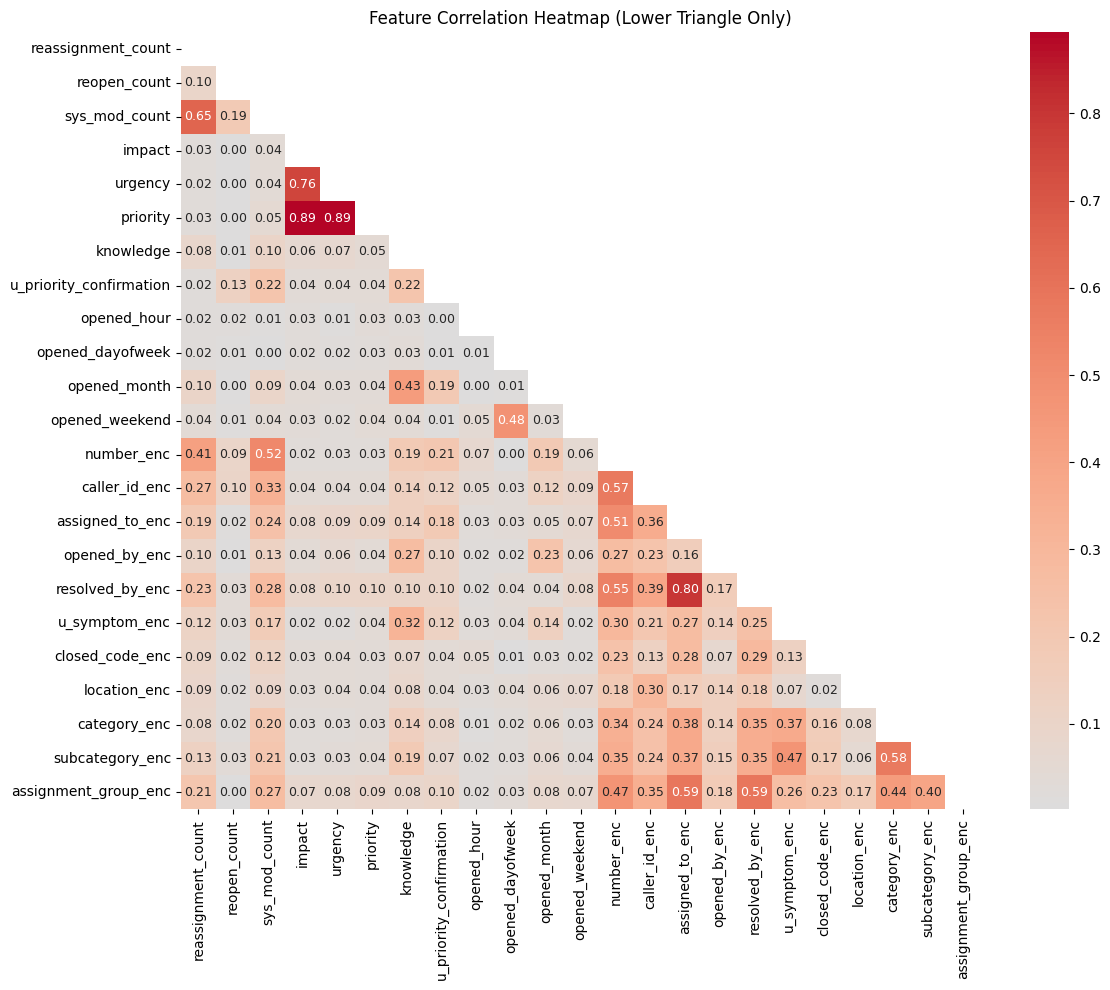

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create mask for the lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,                  # hides lower triangle
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 9}
)
plt.title("Feature Correlation Heatmap (Lower Triangle Only)")
plt.tight_layout()
plt.show()


#####  We Created a New `priority_score_weighted` Column and Dropped `impact`, `urgency`, and `priority`**

In dataset, the features `impact`, `urgency`, and `priority` are highly correlated with each other. This means they carry overlapping or redundant information. For example, `priority` is typically derived from a combination of `impact` and `urgency` in IT service management systems.

Keeping all three in the model could lead to **multicollinearity**, where the model places too much importance on correlated features, potentially reducing its ability to generalize well to new data.

To address this, we created a new column called `priority_score_weighted`, which is a **weighted average** of the three original features:
- `impact` and `urgency` were given higher weights (0.4 each), since they are more direct indicators of issue severity and resolution urgency.
- `priority` was given a lower weight (0.2), as it is often derived from the other two.

This composite feature allows us to retain the **essential information** from all three variables in a single, interpretable score while reducing redundancy.

In [74]:
# Step 3: Compute weighted average from already encoded values
X_tree['priority_score_weighted'] = (
    0.4 * X_tree['impact'] +
    0.4 * X_tree['urgency'] +
    0.2 * X_tree['priority']
)


In [ ]:
#Dropping the original values
X_tree.drop(columns=['impact', 'urgency', 'priority'], inplace=True)

We dropped resolved_by_enc because it's an encoded user ID that doesn’t carry meaningful or generalizable information. In contrast, sys_mod_count reflects how often an incident was updated — a more interpretable and relevant feature for predicting resolution time. Keeping sys_mod_count helps the model focus on incident behavior rather than who resolved it, reducing overfitting to specific individuals.


In [76]:
X_tree.drop(columns=['resolved_by_enc'], inplace=True)

In [77]:
X_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   incident_state           141707 non-null  object 
 1   reassignment_count       141707 non-null  float64
 2   reopen_count             141707 non-null  int64  
 3   sys_mod_count            141707 non-null  float64
 4   contact_type             141707 non-null  object 
 5   impact                   141707 non-null  Int64  
 6   urgency                  141707 non-null  Int64  
 7   priority                 141707 non-null  Int64  
 8   knowledge                141707 non-null  int64  
 9   u_priority_confirmation  141707 non-null  int64  
 10  notify                   141707 non-null  object 
 11  opened_hour              141707 non-null  int32  
 12  opened_dayofweek         141707 non-null  int32  
 13  opened_month             141707 non-null  int32  
 14  opened_we

#### Performing Statistical Tests for Categorical Data using Chi-Square Test


In [78]:
import pandas as pd
from scipy.stats import chi2_contingency

def run_chi_square(col1, col2, data):
    contingency = pd.crosstab(data[col1], data[col2])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\n Chi-Square Test between '{col1}' and '{col2}':")
    print(f"Chi² Statistic = {chi2:.2f}, Degrees of Freedom = {dof}, p-value = {p:.4f}")
    if p < 0.05:
        print("Significant association (dependent)")
    else:
        print(" No significant association (independent)")

# Use df_tree here because it has original categorical variables
run_chi_square('incident_state', 'contact_type', df_tree)
run_chi_square('incident_state', 'notify', df_tree)
run_chi_square('contact_type', 'notify', df_tree)



 Chi-Square Test between 'incident_state' and 'contact_type':
Chi² Statistic = 905.24, Degrees of Freedom = 28, p-value = 0.0000
Significant association (dependent)

 Chi-Square Test between 'incident_state' and 'notify':
Chi² Statistic = 58.84, Degrees of Freedom = 7, p-value = 0.0000
Significant association (dependent)

 Chi-Square Test between 'contact_type' and 'notify':
Chi² Statistic = 76595.93, Degrees of Freedom = 4, p-value = 0.0000
Significant association (dependent)


*This suggests that these features are interdependent and should be considered together during analysis or modeling.


In [79]:
X_tree = pd.get_dummies(X_tree, columns=['incident_state', 'notify', 'contact_type'], drop_first=True , dtype=int )


In [80]:
X_tree.head(5)

,reassignment_count,reopen_count,sys_mod_count,impact,urgency,priority,knowledge,u_priority_confirmation,opened_hour,opened_dayofweek,...,incident_state_Awaiting User Info,incident_state_Awaiting Vendor,incident_state_Closed,incident_state_New,incident_state_Resolved,notify_Send Email,contact_type_Email,contact_type_IVR,contact_type_Phone,contact_type_Self service
0,0.0,0,0.0,2,2,3,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0.0,0,2.0,2,2,3,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0.0,0,3.0,2,2,3,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0.0,0,4.0,2,2,3,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
4,0.0,0,0.0,2,2,3,1,0,4,0,...,0,0,0,1,0,0,0,0,1,0


In [82]:
X_tree.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141707 entries, 0 to 141711
Data columns (total 35 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   reassignment_count                 141707 non-null  float64
 1   reopen_count                       141707 non-null  int64  
 2   sys_mod_count                      141707 non-null  float64
 3   impact                             141707 non-null  Int64  
 4   urgency                            141707 non-null  Int64  
 5   priority                           141707 non-null  Int64  
 6   knowledge                          141707 non-null  int64  
 7   u_priority_confirmation            141707 non-null  int64  
 8   opened_hour                        141707 non-null  int32  
 9   opened_dayofweek                   141707 non-null  int32  
 10  opened_month                       141707 non-null  int32  
 11  opened_weekend                     141707 no

In [83]:
import pandas as pd

# Combine Decision Tree features with target
df_tree_final = pd.concat([X_tree, y.reset_index(drop=True)], axis=1)

# Save to CSV
df_tree_final.to_csv("../../data/processed/preprocessed_decision_tree.csv", index=False)

print("File saved as 'preprocessed_decision_tree.csv'")

File saved as 'preprocessed_decision_tree.csv'


###  Preprocessing Takeaways

- **Outlier handling** was applied to all numeric columns using IQR capping, **except** for `reopen_count`, where all values were 0 and outlier treatment was **not needed**.
- `opened_weekend` was also excluded from IQR capping as it had **no variance** (all values were 0).
- **High-cardinality categorical columns** such as `caller_id`, `assigned_to`, `opened_by`, and others were **target encoded** to reduce dimensionality while preserving their relationship with the target.
- **Low-cardinality categorical columns** like `incident_state`, `contact_type`, and `notify` were **one-hot encoded** to preserve category-level distinctions.
- `impact`, `urgency`, and `priority` were **combined into a single weighted score** (`priority_score_weighted`) to reduce multicollinearity.
- `resolved_by_enc` was **dropped** due to its high correlation with operational features like `sys_mod_count` and its potential to cause overfitting.
- Highly correlated features (Pearson r > 0.75) were removed to ensure model stability.
- **No scaling** was applied, as Decision Trees do not require feature normalization.
- Time-based features such as `opened_hour`, `opened_dayofweek`, and `opened_month` were retained in raw form, as Decision Trees can handle them natively.

**After prediction, the time_to_resolution_log values will be converted back to their original scale using the exponential function (np.expm1 or np.exp) for interpretation.**